**Elo Merchant Category Recommend Competition**
* lightGBM
* Sikit-learn

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# additional imports

import gc
from dask import bag
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import log_loss

from datetime import date, datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

dev = False
use_merchant = False
is_shuffle = True

labelencoder = dict()

**Define utility functions**

In [ ]:
# memory reduce function
# https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# check and show null values
def check_null_val(df) :
    cols = df.columns
    for col in cols :
        null_cnt = df[col].isnull().sum()
        if null_cnt > 0 :
            print(col, '\t', null_cnt)
            
# convert Y/N value to binary value     
def yn_binary_encode(df, column):
    df[column] = df[column].map({'Y':1, 'N':0}).astype(np.int8)
    return df[column]

# convert categorical value to ont-hot-coding
def categorical2onehot(df, features) :
    new_cols = []
    for column in features :
        unique_val = sorted([val for val in df[column].unique().tolist() if str(val) != 'nan'])
        for val in unique_val :
            new_col_name = column + '_' + str(val)
            df[new_col_name] = 0
            df.loc[df[column] == val, new_col_name] = 1
            df[new_col_name] = df[new_col_name].astype(np.int8)
            new_cols.append(new_col_name)
    #df.drop(features, axis = 1, inplace = True)
    return new_cols
    
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint

K = tf.keras.backend

def rmse_metric(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

class MyLayer(tf.keras.layers.Layer):
    def __init__(self, field_dict, field_dim, input_dim, output_dim=30, reg_lambda=0.0, **kwargs):
        self.field_dict = field_dict
        self.field_dim = field_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.reg_lambda = reg_lambda
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.input_dim, self.field_dim, self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)

    def call(self, x):
        self.field_cross = K.variable(0, dtype='float32')
        for i in range(self.input_dim):
            for j in range(i+1, self.input_dim):
                weight = tf.reduce_sum(tf.multiply(self.kernel[i, self.field_dict[j]], self.kernel[j, self.field_dict[i]]))
                value = tf.multiply(weight, tf.multiply(x[:,i], x[:,j]))
                self.field_cross = tf.add(self.field_cross, value)
                
        self.field_cross = tf.add(self.field_cross, self.reg_lambda*0.5*tf.reduce_sum(tf.square(self.kernel)))
        return self.field_cross

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)

class FFM :
    def __init__(self, field_dict, output_dim = 5, lr = 0.001, objective = 'reg', random_state = 2018, reg_lambda = 0.0) :
        print('[FFM] create model...')
        
        self.random_state = random_state
        feature_dim = len(field_dict)
        field_dim = np.unique(np.asarray([f[1] for f in field_dict.items()])).shape[0]
        
        inputs = tf.keras.Input((feature_dim,))
        liner = tf.keras.layers.Dense(1)(inputs)
        cross = MyLayer(field_dict, field_dim, feature_dim, output_dim, reg_lambda)(inputs)
        cross = tf.keras.layers.Reshape((1,))(cross)
        add = tf.keras.layers.Add()([liner, cross])
        
        if objective == 'reg' : 
            predictions = tf.keras.layers.Activation(None)(add)
            obj_loss = rmse_metric
        elif objective == 'binary' :
            predictions = tf.keras.layers.Activation('sigmoid')(add)
            obj_loss = 'binary_crossentropy'
        
        self.model = tf.keras.Model(inputs=inputs, outputs=predictions)
        self.model.compile(loss=obj_loss, optimizer=tf.train.AdamOptimizer(lr))
        self.model.save_weights('model.h5')
        
    def get_weight(self, df_one_hot, target, k = 2, verbose = False) :

        weight = []
        #kfold = KFold(k, shuffle = True)
        kfold = StratifiedKFold(k, shuffle = True, random_state = self.random_state)
        
        print('[FFM] train model...')

        for i, (trn_idx, val_idx) in enumerate(kfold.split(df_one_hot, target < -30)) :
            trn_idx = df_one_hot.index.values[trn_idx]
            val_idx = df_one_hot.index.values[val_idx]
            print("[FFM]", i + 1, 'fold')

            self.model.fit(df_one_hot.loc[trn_idx, :], target[trn_idx]
                    , epochs = 500
                    , batch_size = 512
                    , validation_data = (df_one_hot.loc[val_idx, :], target[val_idx])
                    , verbose = verbose
                    , callbacks = [EarlyStopping(
                        monitor = 'val_loss'
                        , mode='min'
                        , verbose=verbose
                        , restore_best_weights=True
                        , patience=5)]
                    #, seed = self.random_state
                   )
            pred = self.model.predict(df_one_hot.loc[val_idx, :], batch_size = 512)
            print('error :', np.sqrt(np.mean((pred.reshape(-1) - target[val_idx].values)**2)))
             
            weight.append(self.model.layers[1].get_weights()[0])
            self.model.load_weights('model.h5')

        return np.sum(weight, axis = 0) / len(weight)

def get_ffm_vect(field_dict, feature_vect, weight_vect) :
    feature_field = list(field_dict.items())
    feature_num = len(field_dict)
    
    w = np.zeros((feature_vect.shape[0], weight_vect.shape[2]), dtype = np.float64)
    for i in range(feature_num) :
        for j in range(feature_num) :
            wi = feature_vect[:, i].reshape(-1, 1) * weight_vect[i, feature_field[j][1], :].reshape(-1)
            wj = feature_vect[:, j].reshape(-1, 1) * weight_vect[j, feature_field[i][1], :].reshape(-1)
            w += (wi * wj)
    return w

def get_rmse(y_true, y_pred) :
     return np.sqrt(np.mean((y_true - y_pred)**2))
    
def get_agg(df, agg_dict, prefix = '', groupby='card_id') :
    df_agg = df.groupby(groupby).agg(agg_dict)
    df_agg.columns = [prefix + col[0] + '_' + col[1] for col in df_agg.columns]
    if prefix + 'purchase_date_max' in df_agg.columns and prefix + 'purchase_date_min' in df_agg.columns :
        df_agg[prefix + 'purchase_date_ptp'] = df_agg[prefix + 'purchase_date_max'] - df_agg[prefix + 'purchase_date_min']
    return df_agg

**Load  train / test data**

In [1]:
df_train = pd.read_csv("../train.csv")
df_test  = pd.read_csv("../test.csv")

print("df_train : ", df_train.shape)
print("df_test  : ", df_test.shape)
    
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)

df_train.head()

NameError: name 'pd' is not defined

In [ ]:
df_his_tran = pd.read_csv("../../../ELO/historical_transactions.csv")
df_his_tran = reduce_mem_usage(df_his_tran)
print("df_his_tran          : ", df_his_tran.shape)

df_new_tran = pd.read_csv("../../../ELO/new_merchant_transactions.csv")
df_new_tran = reduce_mem_usage(df_new_tran)
print("df_new_merchant_trans: ", df_new_tran.shape)

gc.collect()
df_his_tran.head()

In [ ]:
# fast way to get last historic transaction / first new transaction
last_hist_transaction = df_his_tran.groupby('card_id').agg({'month_lag' : 'max', 'purchase_date' : 'max'}).reset_index()
last_hist_transaction.columns = ['card_id', 'hist_month_lag', 'hist_purchase_date']

# converting to datetime
last_hist_transaction['hist_purchase_date'] = pd.to_datetime(last_hist_transaction['hist_purchase_date']) 

# substracting month_lag for each row
last_hist_transaction['observation_date'] = \
    last_hist_transaction.apply(lambda x: x['hist_purchase_date']  - pd.DateOffset(months=x['hist_month_lag']), axis=1)

last_hist_transaction['observation_date'] = last_hist_transaction['observation_date'].dt.to_period('M').dt.to_timestamp() + pd.DateOffset(months=1)

df_train = df_train.merge(last_hist_transaction[['card_id','observation_date']], on = 'card_id')
df_test = df_test.merge(last_hist_transaction[['card_id','observation_date']], on = 'card_id')

temp = df_his_tran.groupby('card_id').agg({'purchase_date':['min','max']})
temp.columns = ['his_first_date', 'his_last_date']

df_train = df_train.merge(temp, how='left', on='card_id')
df_test = df_test.merge(temp, how='left', on='card_id')

temp = df_new_tran.groupby('card_id').agg({'purchase_date':['min','max']})
temp.columns = ['new_first_date', 'new_last_date']

df_train = df_train.merge(temp, how='left', on='card_id')
df_test = df_test.merge(temp, how='left', on='card_id')

for col in ['his_first_date', 'new_first_date', 'his_last_date', 'new_last_date'] :
    df_train['obv_' + col + '_diff'] = (pd.to_datetime(df_train[col]) - df_train['observation_date']).apply(lambda x : abs(x.days))
    df_test['obv_' + col + '_diff'] = (pd.to_datetime(df_test[col]) - df_test['observation_date']).apply(lambda x : abs(x.days))
    
df_train.drop(['observation_date', 'his_first_date', 'new_first_date', 'his_last_date', 'new_last_date'], axis =1, inplace = True)
df_test.drop(['observation_date', 'his_first_date', 'new_first_date', 'his_last_date', 'new_last_date'], axis =1, inplace = True)
 
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)
    
print(df_train.shape)
df_train.head()

In [2]:
temp = df_his_tran.groupby('card_id').agg({'purchase_date':'max'})
temp.columns = ['last_date']

df_train = df_train.merge(temp, how='left', on='card_id')
df_test = df_test.merge(temp, how='left', on='card_id')


df_test['first_active_month'].fillna(value='2017-01', inplace = True)

df_agg = df_his_tran.groupby('card_id').agg({'purchase_date' : 'min', 'month_lag' : 'min'})
df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')

del df_agg
gc.collect()

df_train['purchase_date'] = df_train['purchase_date'].apply(lambda x : x[:4] + '-' + x[5:7])
df_test['purchase_date'] = df_test['purchase_date'].apply(lambda x : x[:4] + '-' + x[5:7])

df_train.loc[df_train['first_active_month']>df_train['purchase_date'], 'first_active_month'] = df_train.loc[df_train['first_active_month']>df_train['purchase_date'], 'purchase_date']
df_test.loc[df_test['first_active_month']>df_test['purchase_date'], 'first_active_month'] = df_test.loc[df_test['first_active_month']>df_test['purchase_date'], 'purchase_date']

max_date = df_new_tran['purchase_date'].max()
max_date = datetime(int(max_date[:4]), int(max_date[5:7]), int(max_date[8:10]))

df_train['active_period'] = df_train['first_active_month'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), 1)).days).astype(np.int32)
df_test['active_period']  = df_test['first_active_month'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), 1)).days).astype(np.int32)

df_train.drop(['first_active_month'], axis = 1, inplace = True)
df_test.drop(['first_active_month'], axis = 1, inplace = True)

# use purchase_date column as elapsed time feature
df_new_tran['purchase_date'] = df_new_tran['purchase_date'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).days)
df_his_tran['purchase_date'] = df_his_tran['purchase_date'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).days)

df_new_tran['month_diff'] = (df_new_tran['purchase_date']/30) + df_new_tran['month_lag'] 
df_his_tran['month_diff'] = (df_his_tran['purchase_date']/30) + df_his_tran['month_lag'] 

#df_new_tran['duration'] = df_new_tran['purchase_amount'].clip(-1, 1)*df_new_tran['month_diff']
#df_his_tran['duration'] = df_his_tran['purchase_amount'].clip(-1, 1)*df_his_tran['month_diff']

active_period = pd.concat([df_train[['card_id', 'active_period']], df_test[['card_id', 'active_period']]])

df_his_tran = df_his_tran.merge(active_period, how='left', on='card_id')
df_his_tran['active_purchase_diff'] = df_his_tran['active_period'] - df_his_tran['purchase_date']
df_his_tran.drop(['active_period'], axis = 1, inplace = True)

df_new_tran = df_new_tran.merge(active_period, how='left', on='card_id')
df_new_tran['active_purchase_diff'] = df_new_tran['active_period'] - df_new_tran['purchase_date']
df_new_tran.drop(['active_period'], axis = 1, inplace = True)

del active_period

# add positive biased value for summatoin
min_amount = max(abs(df_his_tran['purchase_amount'].min()), abs(df_new_tran['purchase_amount'].min()))
df_his_tran['purchase_amount_pos'] = df_his_tran['purchase_amount'] + min_amount + 0.000001
df_new_tran['purchase_amount_pos'] = df_new_tran['purchase_amount'] + min_amount + 0.000001

# binarize value
df_his_tran['authorized_flag'] = yn_binary_encode(df_his_tran, 'authorized_flag')
df_his_tran['category_1'] = yn_binary_encode(df_his_tran,'category_1')

df_new_tran['authorized_flag'] = yn_binary_encode(df_new_tran, 'authorized_flag')
df_new_tran['category_1'] = yn_binary_encode(df_new_tran, 'category_1')

df_his_tran['installments'] = df_his_tran['installments'].clip(0, 12)
df_new_tran['installments'] = df_new_tran['installments'].clip(0, 12)

categorical_columns = ['category_3', 'category_2']
categorical2onehot(df_his_tran, categorical_columns)
categorical2onehot(df_new_tran, categorical_columns)

df_merchants = pd.read_csv("../input/merchants.csv")
print("df_merchants : ", df_merchants.shape)

df_merchants['category_4'] = yn_binary_encode(df_merchants, 'category_4')

# Range of revenue (monetary units) in last active month --> A > B > C > D > E
#df_merchants.loc[df_merchants['most_recent_sales_range']=='A', 'most_recent_sales_range'] = 5
#df_merchants.loc[df_merchants['most_recent_sales_range']=='B', 'most_recent_sales_range'] = 4
#df_merchants.loc[df_merchants['most_recent_sales_range']=='C', 'most_recent_sales_range'] = 3
#df_merchants.loc[df_merchants['most_recent_sales_range']=='D', 'most_recent_sales_range'] = 2
#df_merchants.loc[df_merchants['most_recent_sales_range']=='E', 'most_recent_sales_range'] = 1
#df_merchants['most_recent_sales_range'] = df_merchants['most_recent_sales_range'].astype(np.int8)

# Range of quantity of transactions in last active month --> A > B > C > D > E
#df_merchants.loc[df_merchants['most_recent_purchases_range']=='A', 'most_recent_purchases_range'] = 5
#df_merchants.loc[df_merchants['most_recent_purchases_range']=='B', 'most_recent_purchases_range'] = 4
#df_merchants.loc[df_merchants['most_recent_purchases_range']=='C', 'most_recent_purchases_range'] = 3
#df_merchants.loc[df_merchants['most_recent_purchases_range']=='D', 'most_recent_purchases_range'] = 2
#df_merchants.loc[df_merchants['most_recent_purchases_range']=='E', 'most_recent_purchases_range'] = 1
#df_merchants['most_recent_purchases_range'] = df_merchants['most_recent_purchases_range'].astype(np.int8)

df_merchants = reduce_mem_usage(df_merchants).groupby('merchant_id').agg({
      'merchant_group_id'       : 'min'
    , 'category_4'              : 'mean'
    #, 'most_recent_sales_range' : 'mean'
    #, 'numerical_1'             : 'mean'
})
df_his_tran = df_his_tran.merge(df_merchants, how='left', on='merchant_id')
df_new_tran = df_new_tran.merge(df_merchants, how='left', on='merchant_id')
del df_merchants

df_his_tran['month_rank'] = df_his_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=False)
df_new_tran['month_rank'] = df_new_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=False)

#df_his_tran['month_rank_reverse'] = df_his_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=True)
#df_new_tran['month_rank_reverse'] = df_new_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=True)

df_his_tran['date_rank'] = df_his_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=True)
df_new_tran['date_rank'] = df_new_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=True)

#df_his_tran['date_rank_reverse'] = df_his_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=False)
#df_new_tran['date_rank_reverse'] = df_new_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=False)

#df_his_tran['amount_rank'] = df_his_tran.groupby(['card_id'])['purchase_amount'].rank(method='dense',ascending=False)
#df_new_tran['amount_rank'] = df_new_tran.groupby(['card_id'])['purchase_amount'].rank(method='dense',ascending=False)

df_his_tran = reduce_mem_usage(df_his_tran)
df_new_tran = reduce_mem_usage(df_new_tran)

gc.collect()
df_his_tran.head()

NameError: name 'df_his_tran' is not defined

In [3]:
# get agg based on date rank

agg_dict = {
     'card_id'          : ['count']
    ,'purchase_amount'  : ['max', 'min']
    ,'installments'     : ['max', 'sum']
    ,'merchant_id'      : ['nunique']
    ,'merchant_group_id': ['nunique']
    ,'category_1'       : ['mean']
}

for rank in range(1, 2) :
    df_agg = get_agg(df_new_tran.loc[df_new_tran['date_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'new_date_' + str(rank) + '_')
    
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
"""
for rank in range(1, 2) :
    df_agg = get_agg(df_new_tran.loc[df_new_tran['date_rank_reverse']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'new_date_reverse_' + str(rank) + '_')
    
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
"""
    
for rank in range(1, 2) :
    df_agg = get_agg(df_his_tran.loc[df_his_tran['date_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'his_date_' + str(rank) + '_')
    
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
"""
for rank in range(1, 2) :
    df_agg = get_agg(df_his_tran.loc[df_his_tran['date_rank_reverse']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'his_date_reverse_' + str(rank) + '_')
    
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
"""
    
print(df_train.shape)
df_train.head()

NameError: name 'get_agg' is not defined

In [8]:
"""
# get agg based on aount rank

agg_dict = {
     'card_id'          : ['count']
    ,'purchase_date'    : ['min']
    ,'month_lag'        : ['max']
    ,'ref_diff'         : ['min', 'mean']
    ,'installments'     : ['max', 'sum']
    ,'merchant_id'      : ['nunique']
    ,'category_1'       : ['mean']
}

for rank in range(1, 2) :
    df_agg = get_agg(df_new_tran.loc[df_new_tran['amount_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'new_amount_rank' + str(rank) + '_')
    
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

for rank in range(1, 2) :
    df_agg = get_agg(df_his_tran.loc[df_his_tran['amount_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'his_amount_rank' + str(rank) + '_')
    
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
print(df_train.shape)
df_train.head()
"""

"\n# get agg based on aount rank\n\nagg_dict = {\n     'card_id'          : ['count']\n    ,'purchase_date'    : ['min']\n    ,'month_lag'        : ['max']\n    ,'ref_diff'         : ['min', 'mean']\n    ,'installments'     : ['max', 'sum']\n    ,'merchant_id'      : ['nunique']\n    ,'category_1'       : ['mean']\n}\n\nfor rank in range(1, 2) :\n    df_agg = get_agg(df_new_tran.loc[df_new_tran['amount_rank']==rank, list(agg_dict.keys())]\n                     , agg_dict, prefix = 'new_amount_rank' + str(rank) + '_')\n    \n    df_train = df_train.merge(df_agg, how='left', on='card_id')\n    df_test = df_test.merge(df_agg, how='left', on='card_id')\n\nfor rank in range(1, 2) :\n    df_agg = get_agg(df_his_tran.loc[df_his_tran['amount_rank']==rank, list(agg_dict.keys())]\n                     , agg_dict, prefix = 'his_amount_rank' + str(rank) + '_')\n    \n    df_train = df_train.merge(df_agg, how='left', on='card_id')\n    df_test = df_test.merge(df_agg, how='left', on='card_id')\n    

In [9]:
# get agg based on month rank

agg_dict = {
     'card_id'             : ['count']
    
    ,'purchase_date'       : ['min', 'max', 'mean', 'std', 'nunique']
    ,'month_diff'          : ['mean']   
     
    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'purchase_amount_pos' : ['sum']
    ,'installments'        : ['min', 'max', 'sum']
    
    ,'category_1'   : ['mean']
    #,'category_3_A' : ['mean']
    ,'category_3_B' : ['mean']
    #,'category_3_C' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    
    ,'authorized_flag'  : ['mean']
    
    #,'most_recent_sales_range' : ['mean']
    #,'numerical_1'             : ['mean']
}

for rank in tqdm(range(1, 3)) :
    prefix = 'month_rank_' + str(rank) + '_'
    df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_rank']==rank), list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    del df_agg
    gc.collect()
    
for rank in tqdm(range(1, 2)) :
    prefix = 'new_month_rank_' + str(rank) + '_'
    df_agg = get_agg(df_new_tran.loc[(df_new_tran['month_rank']==rank), list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    del df_agg
    gc.collect()


print(df_train.shape)
df_train.head()

100%|██████████| 1/1 [00:05<00:00,  5.60s/it]

(201917, 101)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,month_rank_2_purchase_amount_max,month_rank_2_purchase_amount_mean,month_rank_2_purchase_amount_std,month_rank_2_purchase_amount_pos_sum,month_rank_2_installments_min,month_rank_2_installments_max,month_rank_2_installments_sum,month_rank_2_category_1_mean,month_rank_2_category_3_B_mean,month_rank_2_category_4_mean,month_rank_2_merchant_id_nunique,month_rank_2_merchant_category_id_nunique,month_rank_2_merchant_group_id_nunique,month_rank_2_city_id_nunique,month_rank_2_authorized_flag_mean,month_rank_2_purchase_date_ptp,new_month_rank_1_card_id_count,new_month_rank_1_purchase_date_min,new_month_rank_1_purchase_date_max,new_month_rank_1_purchase_date_mean,new_month_rank_1_purchase_date_std,new_month_rank_1_purchase_date_nunique,new_month_rank_1_month_diff_mean,new_month_rank_1_purchase_amount_min,new_month_rank_1_purchase_amount_max,new_month_rank_1_purchase_amount_mean,new_month_rank_1_purchase_amount_std,new_month_rank_1_purchase_amount_pos_sum,new_month_rank_1_installments_min,new_month_rank_1_installments_max,new_month_rank_1_installments_sum,new_month_rank_1_category_1_mean,new_month_rank_1_category_3_B_mean,new_month_rank_1_category_4_mean,new_month_rank_1_merchant_id_nunique,new_month_rank_1_merchant_category_id_nunique,new_month_rank_1_merchant_group_id_nunique,new_month_rank_1_city_id_nunique,new_month_rank_1_authorized_flag_mean,new_month_rank_1_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565583,-0.595230,0,0.0,2,2,0.0,23,64,87,75.652174,6.833132,14,2.521484,-0.738944,-0.496731,-0.676082,0.065388,...,-0.231453,-0.644882,0.118936,2.145974,0,0,0.0,0.000000,0.000000,0.799805,15,14,8,4,1.000000,27,11.0,1.0,24.0,15.636364,8.617108,9.0,2.521484,-0.719727,-0.307861,-0.595703,0.125854,1.664062,0.0,0.0,0.0,0.00,0.00,1.000000,11.0,9.0,9.0,1.0,1.0,23.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.727974,-0.733384,1,3.0,3,2,0.0,51,89,119,101.588235,8.720496,26,3.386719,-0.737892,-0.365264,-0.687415,0.086784,...,0.336609,-0.674757,0.167677,3.398778,0,4,58.0,0.085106,0.829787,0.893555,27,15,20,4,0.957447,30,3.0,31.0,41.0,37.666667,5.773503,2.0,3.255859,-0.733887,-0.701660,-0.716797,0.016174,0.090332,1.0,1.0,3.0,0.00,1.00,1.000000,3.0,3.0,3.0,1.0,1.0,10.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661287,-0.661287,0,0.0,1,1,0.0,1,62,62,62.000000,NaN,1,2.066406,-0.661287,-0.661287,-0.661287,NaN,...,-0.145847,-0.416625,0.382938,0.660893,0,0,0.0,0.000000,0.000000,1.000000,2,2,2,1,1.000000,1,1.0,2.0,2.0,2.000000,NaN,1.0,2.066406,-0.700195,-0.700195,-0.700195,NaN,0.046875,0.0,0.0,0.0,0.00,0.00,1.000000,1.0,1.0,1.0,1.0,1.0,0.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694465

In [10]:
# get agg of each month lag

agg_dict = {
     'card_id'              : ['count']
    
    ,'purchase_date'        : ['min', 'max', 'nunique', 'std']

    ,'purchase_amount'      : ['min', 'max']
    ,'purchase_amount_pos'  : ['sum']
    ,'installments'         : ['min', 'max', 'sum']
    
    ,'category_1'   : ['mean']
    ,'category_3_B' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    
    #,'authorized_flag'  : ['mean']
}

for month in tqdm(sorted(df_his_tran['month_lag'].unique().tolist())) :
    prefix = 'month' + str(month) + '_'
    df_agg = get_agg(df_his_tran.loc[df_his_tran['month_lag']==month, list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
for month in tqdm(sorted(df_new_tran['month_lag'].unique().tolist())) :
    prefix = 'month' + str(month) + '_'
    df_agg = get_agg(df_new_tran.loc[df_new_tran['month_lag']==month, list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

del df_agg
gc.collect()

print(df_train.shape)
df_train.head()

100%|██████████| 2/2 [00:10<00:00,  5.18s/it]


(201917, 405)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,month0_city_id_nunique,month0_purchase_date_ptp,month1_card_id_count,month1_purchase_date_min,month1_purchase_date_max,month1_purchase_date_nunique,month1_purchase_date_std,month1_purchase_amount_min,month1_purchase_amount_max,month1_purchase_amount_pos_sum,month1_installments_min,month1_installments_max,month1_installments_sum,month1_category_1_mean,month1_category_3_B_mean,month1_category_4_mean,month1_merchant_id_nunique,month1_merchant_category_id_nunique,month1_merchant_group_id_nunique,month1_city_id_nunique,month1_purchase_date_ptp,month2_card_id_count,month2_purchase_date_min,month2_purchase_date_max,month2_purchase_date_nunique,month2_purchase_date_std,month2_purchase_amount_min,month2_purchase_amount_max,month2_purchase_amount_pos_sum,month2_installments_min,month2_installments_max,month2_installments_sum,month2_category_1_mean,month2_category_3_B_mean,month2_category_4_mean,month2_merchant_id_nunique,month2_merchant_category_id_nunique,month2_merchant_group_id_nunique,month2_city_id_nunique,month2_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565583,-0.595230,0,0.0,2,2,0.0,23,64,87,75.652174,6.833132,14,2.521484,-0.738944,-0.496731,-0.676082,0.065388,...,1.0,23.0,12.0,30.0,56.0,12.0,10.093502,-0.724609,-0.296143,2.275391,0.0,0.0,0.0,0.0000,0.0000,0.666504,12.0,8.0,9.0,3.0,26.0,11.0,1.0,24.0,9.0,8.617108,-0.719727,-0.307861,1.664062,0.0,0.0,0.0,0.00,0.00,1.000000,11.0,9.0,9.0,1.0,23.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.727974,-0.733384,1,3.0,3,2,0.0,51,89,119,101.588235,8.720496,26,3.386719,-0.737892,-0.365264,-0.687415,0.086784,...,5.0,30.0,3.0,84.0,88.0,2.0,2.309401,-0.739258,-0.731934,0.036621,1.0,1.0,3.0,0.0000,1.0000,1.000000,3.0,2.0,3.0,1.0,4.0,3.0,31.0,41.0,2.0,5.773503,-0.733887,-0.701660,0.090332,1.0,1.0,3.0,0.00,1.00,1.000000,3.0,3.0,3.0,1.0,10.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661287,-0.661287,0,0.0,1,1,0.0,1,62,62,62.000000,NaN,1,2.066406,-0.661287,-0.661287,-0.661287,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,NaN,-0.700195,-0.700195,0.046875,0.0,0.0,0.0,0.00,0.00,1.000000,1.0,1.0,1.0,1.0,0.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694465,-0.694465,1,1.0,1,1,0.0,16,61,86,74.187500,7.747849,10,2.472656,-0.740897,-0.257660,-0.672219,0.118450,...,3.0,25.0,2.0,37.0,54.0,2.0,12.020815,-0.700684,-0.581543,0.211914,1.0,1.0,2.0,0.0000,1.0000,1.000000,2.0,2.0,2.0,1.0,17.0,5.0,12.0,26.0,5.0,6.016644,-0.734375,-0.566895,0.362793,0.0,1.0,4.0,0.20,0.80,1.000000,5.0,4.0,3.0,2.0,14.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2018-02-28 20:40:41,2017-11,-3,180,1.0

In [11]:
# get agg based on month lag range

agg_dict = {
     'card_id'             : ['count']
    
    ,'month_lag'           : ['min', 'max', 'nunique', 'std']
    ,'purchase_date'       : ['min', 'max', 'nunique', 'std']

    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'installments'        : ['max', 'sum']

    ,'category_1'          : ['mean']
    ,'category_3_B'        : ['mean']
    ,'category_4'          : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
}

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_lag']>-4)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'his_month_lag_4_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_lag']>-6)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'his_month_lag_6_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_lag']>-9)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'his_month_lag_9_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

print(df_train.shape)
df_train.head()

(201917, 428)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,month2_purchase_date_max,month2_purchase_date_nunique,month2_purchase_date_std,month2_purchase_amount_min,month2_purchase_amount_max,month2_purchase_amount_pos_sum,month2_installments_min,month2_installments_max,month2_installments_sum,month2_category_1_mean,month2_category_3_B_mean,month2_category_4_mean,month2_merchant_id_nunique,month2_merchant_category_id_nunique,month2_merchant_group_id_nunique,month2_city_id_nunique,month2_purchase_date_ptp,his_month_lag_6_card_id_count,his_month_lag_6_month_lag_min,his_month_lag_6_month_lag_max,his_month_lag_6_month_lag_nunique,his_month_lag_6_month_lag_std,his_month_lag_6_purchase_date_min,his_month_lag_6_purchase_date_max,his_month_lag_6_purchase_date_nunique,his_month_lag_6_purchase_date_std,his_month_lag_6_purchase_amount_min,his_month_lag_6_purchase_amount_max,his_month_lag_6_purchase_amount_mean,his_month_lag_6_purchase_amount_std,his_month_lag_6_installments_max,his_month_lag_6_installments_sum,his_month_lag_6_category_1_mean,his_month_lag_6_category_3_B_mean,his_month_lag_6_category_4_mean,his_month_lag_6_merchant_id_nunique,his_month_lag_6_merchant_category_id_nunique,his_month_lag_6_merchant_group_id_nunique,his_month_lag_6_city_id_nunique,his_month_lag_6_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565583,-0.595230,0,0.0,2,2,0.0,23,64,87,75.652174,6.833132,14,2.521484,-0.738944,-0.496731,-0.676082,0.065388,...,24.0,9.0,8.617108,-0.719727,-0.307861,1.664062,0.0,0.0,0.0,0.00,0.00,1.000000,11.0,9.0,9.0,1.0,23.0,156.0,-5.0,0.0,6.0,1.534211,64.0,240.0,94.0,48.024771,-0.738944,2.258394,-0.607700,0.263873,0.0,0.0,0.000000,0.000000,0.940430,77.0,40.0,59.0,6.0,176.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.727974,-0.733384,1,3.0,3,2,0.0,51,89,119,101.588235,8.720496,26,3.386719,-0.737892,-0.365264,-0.687415,0.086784,...,41.0,2.0,5.773503,-0.733887,-0.701660,0.090332,1.0,1.0,3.0,0.00,1.00,1.000000,3.0,3.0,3.0,1.0,10.0,170.0,-5.0,0.0,6.0,1.659870,89.0,272.0,95.0,52.118511,-0.742400,0.594960,-0.644544,0.176472,10.0,238.0,0.052941,0.805882,0.888184,84.0,42.0,60.0,7.0,183.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661287,-0.661287,0,0.0,1,1,0.0,1,62,62,62.000000,NaN,1,2.066406,-0.661287,-0.661287,-0.661287,NaN,...,2.0,1.0,NaN,-0.700195,-0.700195,0.046875,0.0,0.0,0.0,0.00,0.00,1.000000,1.0,1.0,1.0,1.0,0.0,11.0,-5.0,0.0,5.0,1.673320,62.0,240.0,11.0,56.613522,-0.707809,-0.145847,-0.635395,0.163704,0.0,0.0,0.000000,0.000000,1.000000,5.0,5.0,5.0,1.0,178.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694465,-0.694465,1,1.0,1,1,0.0,16,61,86,74.187500,7.747849,10,2.472656,-0.740897,-0.257660,-0.672219,0.118450,...,26.0,5.0,6.0166

In [12]:
"""
vect_dict = dict()
for col in tqdm(['subsector_id', 'merchant_category_id']) :
    temp = pd.concat([df_his_tran[['card_id',col]],df_new_tran[['card_id',col]]])
    temp[col] = temp[col].apply(lambda x : str(x) + ' ')
    temp = temp.groupby('card_id').agg({col : 'sum'})
    
    vect = CountVectorizer()
    vect = vect.fit_transform(temp[col].values)

    vect_dict[col] = [temp.reset_index()['card_id'], vect]
    
    del temp, vect
    gc.collect()
"""

# get representative subsector_id

for col in tqdm(['subsector_id']) :
    df = pd.concat([df_his_tran.loc[df_his_tran['authorized_flag']==1,['card_id', col]], df_new_tran[['card_id', col]]]).groupby(['card_id', col]).agg({col:'count'})
    df['rank'] = df.groupby('card_id')[col].rank(method='first', ascending=False)
    
    df = df.drop([col], axis = 1).reset_index()
    for rank in range(1, 2) :
        temp = df.loc[df['rank']==rank, ['card_id', col]]
        temp.columns = ['card_id', col + '_rank_' + str(rank)]
        df_train = df_train.merge(temp, how='left', on='card_id')
        df_test = df_test.merge(temp, how='left', on='card_id')
    
    del df, temp
    gc.collect()
    
print(df_train.shape)
df_train.head()

100%|██████████| 1/1 [00:16<00:00, 16.53s/it]

(201917, 429)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,month2_purchase_date_nunique,month2_purchase_date_std,month2_purchase_amount_min,month2_purchase_amount_max,month2_purchase_amount_pos_sum,month2_installments_min,month2_installments_max,month2_installments_sum,month2_category_1_mean,month2_category_3_B_mean,month2_category_4_mean,month2_merchant_id_nunique,month2_merchant_category_id_nunique,month2_merchant_group_id_nunique,month2_city_id_nunique,month2_purchase_date_ptp,his_month_lag_6_card_id_count,his_month_lag_6_month_lag_min,his_month_lag_6_month_lag_max,his_month_lag_6_month_lag_nunique,his_month_lag_6_month_lag_std,his_month_lag_6_purchase_date_min,his_month_lag_6_purchase_date_max,his_month_lag_6_purchase_date_nunique,his_month_lag_6_purchase_date_std,his_month_lag_6_purchase_amount_min,his_month_lag_6_purchase_amount_max,his_month_lag_6_purchase_amount_mean,his_month_lag_6_purchase_amount_std,his_month_lag_6_installments_max,his_month_lag_6_installments_sum,his_month_lag_6_category_1_mean,his_month_lag_6_category_3_B_mean,his_month_lag_6_category_4_mean,his_month_lag_6_merchant_id_nunique,his_month_lag_6_merchant_category_id_nunique,his_month_lag_6_merchant_group_id_nunique,his_month_lag_6_city_id_nunique,his_month_lag_6_purchase_date_ptp,subsector_id_rank_1
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565583,-0.595230,0,0.0,2,2,0.0,23,64,87,75.652174,6.833132,14,2.521484,-0.738944,-0.496731,-0.676082,0.065388,...,9.0,8.617108,-0.719727,-0.307861,1.664062,0.0,0.0,0.0,0.00,0.00,1.000000,11.0,9.0,9.0,1.0,23.0,156.0,-5.0,0.0,6.0,1.534211,64.0,240.0,94.0,48.024771,-0.738944,2.258394,-0.607700,0.263873,0.0,0.0,0.000000,0.000000,0.940430,77.0,40.0,59.0,6.0,176.0,34
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.727974,-0.733384,1,3.0,3,2,0.0,51,89,119,101.588235,8.720496,26,3.386719,-0.737892,-0.365264,-0.687415,0.086784,...,2.0,5.773503,-0.733887,-0.701660,0.090332,1.0,1.0,3.0,0.00,1.00,1.000000,3.0,3.0,3.0,1.0,10.0,170.0,-5.0,0.0,6.0,1.659870,89.0,272.0,95.0,52.118511,-0.742400,0.594960,-0.644544,0.176472,10.0,238.0,0.052941,0.805882,0.888184,84.0,42.0,60.0,7.0,183.0,34
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661287,-0.661287,0,0.0,1,1,0.0,1,62,62,62.000000,NaN,1,2.066406,-0.661287,-0.661287,-0.661287,NaN,...,1.0,NaN,-0.700195,-0.700195,0.046875,0.0,0.0,0.0,0.00,0.00,1.000000,1.0,1.0,1.0,1.0,0.0,11.0,-5.0,0.0,5.0,1.673320,62.0,240.0,11.0,56.613522,-0.707809,-0.145847,-0.635395,0.163704,0.0,0.0,0.000000,0.000000,1.000000,5.0,5.0,5.0,1.0,178.0,33
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694465,-0.694465,1,1.0,1,1,0.0,16,61,86,74.187500,7.747849,10,2.472656,-0.740897,-0.257660,-0.672219,0.118450,...,5.0,6.016644,-0.734375,-0

In [13]:
# get agg based on unauthorized flag

agg_dict = {
     'card_id'             : ['count']
    
    ,'month_lag'           : ['min', 'max', 'mean', 'nunique', 'std']
    ,'purchase_date'       : ['min', 'max', 'mean', 'nunique', 'std']
    ,'active_purchase_diff': ['max']
    ,'month_diff'          : ['min', 'max', 'mean']
     
    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'installments'        : ['max', 'sum']
    ,'purchase_amount_pos' : ['sum']
    
    ,'category_1'   : ['mean']
    ,'category_3_A' : ['mean']
    ,'category_3_B' : ['mean']
    ,'category_3_C' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'subsector_id'         : ['nunique']
}

df_agg = get_agg(df_his_tran.loc[df_his_tran['authorized_flag']==0, list(agg_dict.keys())]
                 , agg_dict, prefix = 'den_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['category_1']==1)&(df_his_tran['authorized_flag']==0), list(agg_dict.keys())]
                 , agg_dict, prefix = 'den_ca1_1_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

agg_dict = {
     'card_id'             : ['count']
    
    ,'purchase_date'       : ['min', 'max', 'nunique', 'std']
    ,'month_diff'          : ['mean']
    
    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'installments'        : ['max', 'sum']
    ,'purchase_amount_pos' : ['sum']
    
    ,'category_1'   : ['mean']
    ,'category_3_A' : ['mean']
    ,'category_3_B' : ['mean']
    ,'category_3_C' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'subsector_id'         : ['nunique']
}

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['authorized_flag']==0)&(df_his_tran['month_rank']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'den_month1_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

del df_agg
gc.collect()

print(df_train.shape)
df_train.head()

(201917, 463)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,his_month_lag_6_merchant_id_nunique,his_month_lag_6_merchant_category_id_nunique,his_month_lag_6_merchant_group_id_nunique,his_month_lag_6_city_id_nunique,his_month_lag_6_purchase_date_ptp,subsector_id_rank_1,den_card_id_count,den_month_lag_min,den_month_lag_max,den_month_lag_mean,den_month_lag_nunique,den_month_lag_std,den_purchase_date_min,den_purchase_date_max,den_purchase_date_mean,den_purchase_date_nunique,den_purchase_date_std,den_active_purchase_diff_max,den_month_diff_min,den_month_diff_max,den_month_diff_mean,den_purchase_amount_min,den_purchase_amount_max,den_purchase_amount_mean,den_purchase_amount_std,den_installments_max,den_installments_sum,den_purchase_amount_pos_sum,den_category_1_mean,den_category_3_A_mean,den_category_3_B_mean,den_category_3_C_mean,den_category_4_mean,den_merchant_id_nunique,den_merchant_category_id_nunique,den_merchant_group_id_nunique,den_city_id_nunique,den_state_id_nunique,den_subsector_id_nunique,den_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565583,-0.595230,0,0.0,2,2,0.0,23,64,87,75.652174,6.833132,14,2.521484,-0.738944,-0.496731,-0.676082,0.065388,...,77.0,40.0,59.0,6.0,176.0,34,13.0,-7.0,-2.0,-4.461538,6.0,1.664101,124.0,289.0,212.461538,13.0,52.191339,209.0,2.066406,2.933594,2.621094,-0.737892,-0.431922,-0.659363,0.098851,1.0,4.0,1.140204,0.000000,0.692308,0.307692,0.000000,0.916504,12.0,10.0,7.0,2.0,1.0,7.0,165.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.727974,-0.733384,1,3.0,3,2,0.0,51,89,119,101.588235,8.720496,26,3.386719,-0.737892,-0.365264,-0.687415,0.086784,...,84.0,42.0,60.0,7.0,183.0,34,11.0,-10.0,-1.0,-4.454545,6.0,2.696799,123.0,423.0,238.818182,9.0,89.469345,361.0,3.066406,4.101562,3.505859,-0.740897,1.942838,-0.102081,0.785906,10.0,42.0,7.094898,0.181818,0.000000,0.363636,0.636364,1.000000,9.0,9.0,6.0,2.0,2.0,9.0,300.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661287,-0.661287,0,0.0,1,1,0.0,1,62,62,62.000000,NaN,1,2.066406,-0.661287,-0.661287,-0.661287,NaN,...,5.0,5.0,5.0,1.0,178.0,33,2.0,-12.0,-10.0,-11.000000,2.0,1.414214,374.0,431.0,402.500000,2.0,40.305087,263.0,2.367188,2.466797,2.417969,-0.701453,-0.637515,-0.669484,0.045211,0.0,0.0,0.155175,0.000000,1.000000,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,57.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694465,-0.694465,1,1.0,1,1,0.0,16,61,86,74.187500,7.747849,10,2.472656,-0.740897,-0.257660,-0.672219,0.118450,...,50.0,25.0,39.0,7.0,155.0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2018-02-28 20:40

In [14]:
# get agg based on category information

for col, prefix in zip([
    'category_1',
    'category_4',
    #'category_3_A',
    #'category_3_B',
    'category_3_C']
    ,['ca1_',
      'ca4_',
      #'ca3_A_',
      #'ca3_B_',
      'ca3_C_']) :

    print(col, prefix)
    
    agg_dict = {
         'card_id'             : ['count']

        ,'month_lag'           : ['min', 'max', 'mean', 'nunique', 'std']
        ,'purchase_date'       : ['min', 'max', 'mean', 'nunique', 'std']
        ,'month_diff'          : ['mean']
        ,'ref_diff'            : ['mean', 'min', 'max']

        ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
        ,'installments'        : ['min', 'max', 'sum']
        ,'purchase_amount_pos' : ['sum']

        ,'merchant_id'          : ['nunique']
        ,'merchant_category_id' : ['nunique']
        ,'merchant_group_id'    : ['nunique']
        ,'city_id'              : ['nunique']
        ,'state_id'             : ['nunique']
    }
    
    df_agg = get_agg(pd.concat([
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
        , df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1), list(agg_dict.keys())]
    ]), agg_dict, prefix = 'tot_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    if col == 'category_3_C' or col == 'category_4' : continue
    
    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    agg_dict = {
         'card_id'             : ['count']

        ,'purchase_date'       : ['min', 'max', 'mean', 'nunique', 'std']
        ,'month_diff'          : ['mean']
        ,'ref_diff'            : ['mean']

        ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
        ,'installments'        : ['min', 'max', 'mean', 'sum']

        ,'merchant_id'          : ['nunique']
        ,'merchant_category_id' : ['nunique']
        ,'merchant_group_id'    : ['nunique']
        ,'city_id'              : ['nunique']
    }

    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['month_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_month1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    """
    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['month_rank_reverse']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_month_reverse1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    agg_dict = {
         'card_id'             : ['count']

        ,'ref_diff'            : ['mean']
        
        ,'purchase_amount'     : ['min', 'max']
        ,'installments'        : ['max', 'sum']

        ,'merchant_id'          : ['nunique']
    }

    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['date_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_date1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['date_rank_reverse']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_date_reverse1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1)&(df_new_tran['date_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_date1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1)&(df_new_tran['date_rank_reverse']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_date_reverse1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
    # amount rank agg
    agg_dict = {
         'card_id'             : ['count']
        
        ,'month_lag'           : ['min']
        ,'purchase_date'       : ['min']
        ,'installments'        : ['max', 'min']

        ,'ref_diff'            : ['min']
        
        ,'merchant_id'          : ['nunique']
        ,'merchant_group_id'    : ['nunique']
        ,'merchant_category_id' : ['nunique']
    }
    
    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['amount_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_amount_rank1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1)&(df_new_tran['amount_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_amount_rank1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    """
    
    del df_agg
    gc.collect()

print(df_train.shape)
df_train.head()

category_1 ca1_
category_4 ca4_
category_3_C ca3_C_
(201917, 629)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,tot_ca4_purchase_amount_std,tot_ca4_installments_min,tot_ca4_installments_max,tot_ca4_installments_sum,tot_ca4_purchase_amount_pos_sum,tot_ca4_merchant_id_nunique,tot_ca4_merchant_category_id_nunique,tot_ca4_merchant_group_id_nunique,tot_ca4_city_id_nunique,tot_ca4_state_id_mean,tot_ca4_purchase_date_ptp,tot_ca3_C_card_id_count,tot_ca3_C_month_lag_min,tot_ca3_C_month_lag_max,tot_ca3_C_month_lag_mean,tot_ca3_C_month_lag_nunique,tot_ca3_C_month_lag_std,tot_ca3_C_purchase_date_min,tot_ca3_C_purchase_date_max,tot_ca3_C_purchase_date_mean,tot_ca3_C_purchase_date_nunique,tot_ca3_C_purchase_date_std,tot_ca3_C_month_diff_mean,tot_ca3_C_ref_diff_mean,tot_ca3_C_ref_diff_min,tot_ca3_C_ref_diff_max,tot_ca3_C_purchase_amount_min,tot_ca3_C_purchase_amount_max,tot_ca3_C_purchase_amount_mean,tot_ca3_C_purchase_amount_std,tot_ca3_C_installments_min,tot_ca3_C_installments_max,tot_ca3_C_installments_sum,tot_ca3_C_purchase_amount_pos_sum,tot_ca3_C_merchant_id_nunique,tot_ca3_C_merchant_category_id_nunique,tot_ca3_C_merchant_group_id_nunique,tot_ca3_C_city_id_nunique,tot_ca3_C_state_id_mean,tot_ca3_C_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565583,-0.595230,0,0.0,2,2,0.0,23,64,87,75.652174,6.833132,14,2.521484,-0.738944,-0.496731,-0.676082,0.065388,...,0.216592,0.0,0.0,0.0,28.864096,102.0,42.0,78.0,1.0,9.000000,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.727974,-0.733384,1,3.0,3,2,0.0,51,89,119,101.588235,8.720496,26,3.386719,-0.737892,-0.365264,-0.687415,0.086784,...,0.367875,0.0,10.0,479.0,42.221043,121.0,54.0,88.0,3.0,8.101266,448.0,65.0,-12.0,0.0,-6.215385,13.0,4.086916,93.0,475.0,293.476923,51.0,125.514579,3.566406,NaN,NaN,NaN,-0.682624,4.630300,-0.264935,0.708236,2.0,10.0,231.0,31.338861,43.0,25.0,33.0,3.0,7.153846,382.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661287,-0.661287,0,0.0,1,1,0.0,1,62,62,62.000000,NaN,1,2.066406,-0.661287,-0.661287,-0.661287,NaN,...,0.091012,0.0,0.0,0.0,2.750933,11.0,8.0,8.0,2.0,5.102564,470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694465,-0.694465,1,1.0,1,1,0.0,16,61,86,74.187500,7.747849,10,2.472656,-0.740897,-0.257660,-0.672219,0.118450,...,0.254095,0.0,3.0,90.0,8.349802,55.0,28.0,41.0,6.0,16.634146,204.0,7.0,-4.0,0.0,-2.428571,3.0,1.718249,82.0,202.0,150.142857,6.0,49.391054,2.576172,NaN,NaN,NaN,-0.570617,-0.257660,-0.436441,0.132175,2.0,3.0,18.0,2.174414,6.0,6.0,5.0,2.0,2.285714,120.0
4,C_ID_cdbd2c0d

In [15]:
# get agg from total data

agg_dict = {
     'card_id'         : ['count']
    
    ,'category_1'      : ['mean']
    ,'category_4'      : ['mean']
    
    ,'category_3_A'    : ['mean']
    ,'category_3_B'    : ['mean']
    ,'category_3_C'    : ['mean']
    
    ,'category_2_1.0'  : ['mean']
    ,'category_2_2.0'  : ['mean']
    ,'category_2_3.0'  : ['mean']
    ,'category_2_4.0'  : ['mean']
    ,'category_2_5.0'  : ['mean']
    
    ,'merchant_category_id' : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'subsector_id'         : ['nunique']
    ,'merchant_group_id'    : ['nunique']
}

df_agg = get_agg(pd.concat([df_his_tran.loc[:,list(agg_dict.keys())], df_new_tran.loc[:,list(agg_dict.keys())]])
                 , agg_dict, prefix = 'tot_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')

del df_agg
gc.collect()

print(df_train.shape)
df_train.head()

(201917, 645)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,tot_ca3_C_month_lag_std,tot_ca3_C_purchase_date_min,tot_ca3_C_purchase_date_max,tot_ca3_C_purchase_date_mean,tot_ca3_C_purchase_date_nunique,tot_ca3_C_purchase_date_std,tot_ca3_C_month_diff_mean,tot_ca3_C_ref_diff_mean,tot_ca3_C_ref_diff_min,tot_ca3_C_ref_diff_max,tot_ca3_C_purchase_amount_min,tot_ca3_C_purchase_amount_max,tot_ca3_C_purchase_amount_mean,tot_ca3_C_purchase_amount_std,tot_ca3_C_installments_min,tot_ca3_C_installments_max,tot_ca3_C_installments_sum,tot_ca3_C_purchase_amount_pos_sum,tot_ca3_C_merchant_id_nunique,tot_ca3_C_merchant_category_id_nunique,tot_ca3_C_merchant_group_id_nunique,tot_ca3_C_city_id_nunique,tot_ca3_C_state_id_mean,tot_ca3_C_purchase_date_ptp,tot_card_id_count,tot_category_1_mean,tot_category_4_mean,tot_category_3_A_mean,tot_category_3_B_mean,tot_category_3_C_mean,tot_category_2_1.0_mean,tot_category_2_2.0_mean,tot_category_2_3.0_mean,tot_category_2_4.0_mean,tot_category_2_5.0_mean,tot_merchant_category_id_nunique,tot_city_id_nunique,tot_state_id_nunique,tot_subsector_id_nunique,tot_merchant_group_id_nunique
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565583,-0.595230,0,0.0,2,2,0.0,23,64,87,75.652174,6.833132,14,2.521484,-0.738944,-0.496731,-0.676082,0.065388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283,0.000000,0.942383,0.985866,0.014134,0.000000,0.989399,0.0,0.00000,0.000000,0.010601,46,9,3,21,88
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.727974,-0.733384,1,3.0,3,2,0.0,51,89,119,101.588235,8.720496,26,3.386719,-0.737892,-0.365264,-0.687415,0.086784,...,4.086916,93.0,475.0,293.476923,51.0,125.514579,3.566406,NaN,NaN,NaN,-0.682624,4.630300,-0.264935,0.708236,2.0,10.0,231.0,31.338861,43.0,25.0,33.0,3.0,7.153846,382.0,356,0.087079,0.918457,0.000000,0.792135,0.202247,0.912921,0.0,0.00000,0.000000,0.000000,58,9,3,24,106
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661287,-0.661287,0,0.0,1,1,0.0,1,62,62,62.000000,NaN,1,2.066406,-0.661287,-0.661287,-0.661287,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,0.000000,0.931641,1.000000,0.000000,0.000000,0.090909,0.0,0.00000,0.000000,0.909091,9,5,2,8,10
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694465,-0.694465,1,1.0,1,1,0.0,16,61,86,74.187500,7.747849,10,2.472656,-0.740897,-0.257660,-0.672219,0.118450,...,1.718249,82.0,202.0,150.142857,6.0,49.391054,2.576172,NaN,NaN,NaN,-0.570617,-0.257660,-0.436441,0.132175,2.0,3.0,18.0,2.174414,6.0,6.0,5.0,2.0,2.285714,120.0,84,0.154762,0.976074,0.000000,0.880952,0.083333,0.142857,0.0,0.00000,0.702381,0.000000,28,7,5,15,43
4,C_ID_cdbd2c0db2,1,3,0,-0.15979

In [16]:
# get agg from new / his split transactions

agg_dict = {
    'card_id' : ['count']

    ,'purchase_amount'      : ['min', 'max', 'mean', 'median', 'std', 'sum']
    ,'purchase_amount_pos'  : ['sum']
    ,'installments'         : ['max', 'sum']

    ,'active_purchase_diff' : ['min', 'max']
    
    ,'purchase_date'        : ['min', 'max', 'mean', 'median', 'std', 'nunique']
    ,'month_lag'            : ['min', 'max', 'mean', 'median', 'std', 'nunique']

    ,'month_diff'           : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'subsector_id'         : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'merchant_group_id'    : ['nunique']

    ,'category_1'      : ['mean']
    
    ,'category_3_A'    : ['mean']
    ,'category_3_B'    : ['mean']
    ,'category_3_C'    : ['mean']
    
    ,'category_4'      : ['mean']
}

df_agg = get_agg(df_new_tran[df_new_tran['authorized_flag']==1], agg_dict, 'new_')
del df_new_tran
gc.collect() 

df_train = df_train.merge(df_agg, how='left', on=['card_id'])
df_test = df_test.merge(df_agg, how='left', on=['card_id'])

del df_agg
gc.collect()

print(df_train.shape)

df_agg = get_agg(df_his_tran[df_his_tran['authorized_flag']==1], agg_dict, 'his_')
del df_his_tran
gc.collect() 

df_train = df_train.merge(df_agg, how='left', on=['card_id'])
df_test  = df_test.merge(df_agg, how='left', on=['card_id'])

del df_agg
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)
gc.collect() 

print(df_train.shape)
df_train.head()

(201917, 682)
Mem. usage decreased to 305.98 Mb (67.0% reduction)
Mem. usage decreased to 185.45 Mb (67.4% reduction)
(201917, 719)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,new_category_3_C_mean,new_category_4_mean,new_purchase_date_ptp,his_card_id_count,his_purchase_amount_min,his_purchase_amount_max,his_purchase_amount_mean,his_purchase_amount_median,his_purchase_amount_std,his_purchase_amount_sum,his_purchase_amount_pos_sum,his_installments_max,his_installments_sum,his_active_purchase_diff_min,his_active_purchase_diff_max,his_purchase_date_min,his_purchase_date_max,his_purchase_date_mean,his_purchase_date_median,his_purchase_date_std,his_purchase_date_nunique,his_month_lag_min,his_month_lag_max,his_month_lag_mean,his_month_lag_median,his_month_lag_std,his_month_lag_nunique,his_month_diff_mean,his_merchant_id_nunique,his_merchant_category_id_nunique,his_subsector_id_nunique,his_city_id_nunique,his_state_id_nunique,his_merchant_group_id_nunique,his_category_1_mean,his_category_3_A_mean,his_category_3_B_mean,his_category_3_C_mean,his_category_4_mean,his_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565430,-0.595215,0,0.0,2,2,0.000000,23,64,87,75.6250,6.832031,14,2.521484,-0.738770,-0.496731,-0.676270,0.065369,...,0.000000,0.826172,55.0,247,-0.739258,2.257812,-0.637207,-0.697266,0.216553,-157.375000,27.125000,0,0.0,26,269,64,307,192.750,191.0,75.18750,149,-8,0,-3.882812,-4.0,2.429688,9,2.541016,93,41,21,7,3,73,0.000000,1.0,0.000000,0.000000,0.954590,243
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.728027,-0.733398,1,3.0,3,2,0.000000,51,89,119,101.5625,8.718750,26,3.386719,-0.737793,-0.365264,-0.687500,0.086792,...,0.000000,1.000000,57.0,339,-0.742188,4.628906,-0.616211,-0.708984,0.355469,-208.875000,44.375000,10,503.0,5,395,89,479,257.750,272.0,117.81250,200,-12,0,-5.050781,-5.0,3.837891,13,3.539062,141,57,24,9,3,100,0.085571,0.0,0.802246,0.191772,0.914551,390
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661133,-0.661133,0,0.0,1,1,0.000000,1,62,62,62.0000,NaN,1,2.066406,-0.661133,-0.661287,-0.661133,NaN,...,0.000000,1.000000,0.0,41,-0.729980,-0.145874,-0.678711,-0.698730,0.089233,-27.828125,2.800781,0,0.0,163,575,62,474,329.250,366.0,118.68750,34,-13,0,-8.484375,-10.0,3.892578,12,2.488281,13,8,7,5,2,9,0.000000,1.0,0.000000,0.000000,0.926758,412
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694336,-0.694336,1,1.0,1,1,0.000000,16,61,86,74.1875,7.746094,10,2.472656,-0.740723,-0.257660,-0.672363,0.118469,...,0.000000,1.000000,42.0,77,-0.740723,1.445312,-0.642578,-0.708008,0.261719,-49.500000,8.031250,3,86.0,25,180,61,216,159.125,186.0,53.37500,47,-5,0,-2.832031,-4.0,1.801758,6,2.472656,50,25,13,7,5,39,0.155884,0.0,0.883301,0.090881,0.974121,155
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2018-02-28 20:40:41,2017-11,-3,180,1.0,-0.632812,-0

In [17]:
import re

def fill_null_val() :
    fill_zero = [
         'card_id_count'
        ,'purchase_amount_pos_sum'
        ,'purchase_amount_log_sum'

        ,'purchase_date_nunique'
        ,'purchase_date_ptp'

        ,'month_lag_nunique'

        ,'month_lag_card_id_count_median'
        ,'purchase_date_card_id_count_median'

        ,'month_lag_purchase_amount_pos_sum_median'
        ,'purchase_date_purchase_amount_pos_sum_median'

        ,'category_4_mean'
        ,'category_1_mean'

        ,'category_3_A_mean'
        ,'category_3_B_mean'
        ,'category_3_C_mean'

        ,'category_2_1.0_mean'
        ,'category_2_3.0_mean'
        ,'category_2_2.0_mean'
        ,'category_2_4.0_mean'
        ,'category_2_5.0_mean'

        ,'merchant_id_nunique'
        ,'merchant_category_id_nunique'
        ,'subsector_id_nunique'
        ,'city_id_nunique'
        ,'state_id_nunique'
        ,'merchant_group_id_nunique'

        ,'weekofyear_nunique'
        ,'day_nunique'
    ]

    for f in df_train.columns :
        for col in fill_zero :
            if len(re.findall(col, f)) != 0 :
                df_train[f].fillna(value = 0.0, inplace = True)
                df_test[f].fillna(value = 0.0, inplace = True)

fill_null_val()
check_null_val(df_train)

obv_new_first_date_diff 	 21931
obv_new_last_date_diff 	 21931
new_date_1_purchase_amount_max 	 21931
new_date_1_purchase_amount_min 	 21931
new_date_1_installments_max 	 21931
new_date_1_installments_sum 	 21931
month_rank_1_purchase_date_std 	 25187
month_rank_1_purchase_amount_std 	 25187
month_rank_2_purchase_date_std 	 23385
month_rank_2_purchase_amount_std 	 23385
new_month_rank_1_purchase_date_min 	 21931
new_month_rank_1_purchase_date_max 	 21931
new_month_rank_1_purchase_date_mean 	 21931
new_month_rank_1_purchase_date_std 	 76095
new_month_rank_1_month_diff_mean 	 21931
new_month_rank_1_purchase_amount_min 	 21931
new_month_rank_1_purchase_amount_max 	 21931
new_month_rank_1_purchase_amount_mean 	 21931
new_month_rank_1_purchase_amount_std 	 76095
new_month_rank_1_installments_min 	 21931
new_month_rank_1_installments_max 	 21931
new_month_rank_1_installments_sum 	 21931
new_month_rank_1_authorized_flag_mean 	 21931
month-13_purchase_date_min 	 160476
month-13_purchase_date_m

his_month1_ca1_installments_max 	 156673
his_month1_ca1_installments_mean 	 156673
his_month1_ca1_installments_sum 	 156673
tot_ca4_month_lag_min 	 8027
tot_ca4_month_lag_max 	 8027
tot_ca4_month_lag_mean 	 8027
tot_ca4_month_lag_std 	 18194
tot_ca4_purchase_date_min 	 8027
tot_ca4_purchase_date_max 	 8027
tot_ca4_purchase_date_mean 	 8027
tot_ca4_purchase_date_std 	 18194
tot_ca4_month_diff_mean 	 8027
tot_ca4_ref_diff_mean 	 201917
tot_ca4_ref_diff_min 	 201917
tot_ca4_ref_diff_max 	 201917
tot_ca4_purchase_amount_min 	 8027
tot_ca4_purchase_amount_max 	 8027
tot_ca4_purchase_amount_mean 	 8027
tot_ca4_purchase_amount_std 	 18194
tot_ca4_installments_min 	 8027
tot_ca4_installments_max 	 8027
tot_ca4_installments_sum 	 8027
tot_ca4_state_id_mean 	 8027
tot_ca3_C_month_lag_min 	 103340
tot_ca3_C_month_lag_max 	 103340
tot_ca3_C_month_lag_mean 	 103340
tot_ca3_C_month_lag_std 	 110831
tot_ca3_C_purchase_date_min 	 103340
tot_ca3_C_purchase_date_max 	 103340
tot_ca3_C_purchase_date_mean

In [18]:
def make_all_time_features(df) :
    
    tot_count = df['new_card_id_count'] + df['his_card_id_count']
    tot_amount= df['new_purchase_amount_pos_sum'] + df['his_purchase_amount_pos_sum']
    tot_date  = df['new_purchase_date_nunique'] + df['his_purchase_date_nunique']
    tot_month = df['new_month_lag_nunique'] + df['his_month_lag_nunique']
    
    df['tot_count'] = tot_count
    df['tot_amount'] = tot_amount

    df['tot_purchase_date_nunique'] = tot_date
    df['tot_month_lag_nunique'] = tot_month
    
    #################
    df['new_month_lag_ptp'] = abs(df['new_month_lag_max'] - df['new_month_lag_min'])
    df['his_month_lag_ptp'] = abs(df['his_month_lag_max'] - df['his_month_lag_min'])
    df['tot_month_lag_ptp'] = abs(df['new_month_lag_max'] - df['his_month_lag_min'])
    df.loc[df['tot_month_lag_ptp'].isnull(), 'tot_month_lag_ptp'] = df.loc[df['tot_month_lag_ptp'].isnull(), 'his_month_lag_ptp']
    
    df['new_purchase_date_ptp']  = df['new_purchase_date_max'] - df['new_purchase_date_min']
    df['his_purchase_date_ptp']  = df['his_purchase_date_max'] - df['his_purchase_date_min']
    df['tot_purchase_date_ptp']  = df['his_purchase_date_min'] - df['new_purchase_date_max']
    df.loc[df['tot_purchase_date_ptp'].isnull(), 'tot_purchase_date_ptp'] = df.loc[df['tot_purchase_date_ptp'].isnull(), 'his_purchase_date_ptp']

    df['tot_purchase_date_nunique_mean'] = df['tot_purchase_date_nunique'] / tot_count
    
    df['new_day_coverage'] = df['new_purchase_date_nunique'] / df['new_purchase_date_ptp']
    df['his_day_coverage'] = df['his_purchase_date_nunique'] / df['his_purchase_date_ptp']
    df['tot_day_coverage'] = tot_date / df['tot_purchase_date_ptp']
    
    df['new_month_coverage'] = df['new_month_lag_nunique'] / df['new_month_lag_ptp']
    df['his_month_coverage'] = df['his_month_lag_nunique'] / df['his_month_lag_ptp']
    df['tot_month_coverage'] = tot_month / df['tot_month_lag_ptp']
    #######################
    df['new_count_ratio']   = df['new_card_id_count'] / tot_count
    df['new_amount_ratio']  = df['new_purchase_amount_pos_sum'] / tot_amount
    df['new_date_ratio']    = df['new_purchase_date_nunique'] / tot_date
    df['new_month_ratio']   = df['new_month_lag_nunique'] / tot_month
    
    df['deny_count_ratio']  = df['den_card_id_count'] / (tot_count - df['new_card_id_count'])
    #df['deny_amount_ratio'] = df['den_purchase_amount_pos_sum'] / df['his_purchase_amount_pos_sum']
    df['deny_date_ratio']   = df['den_purchase_date_nunique'] / df['his_purchase_date_nunique']
    df['deny_month_ratio']  = df['den_month_lag_nunique'] / df['his_month_lag_nunique']
    #######################
    df['new_merchant_id_nunique_mean'] = df['new_merchant_id_nunique'] / df['new_card_id_count']
    df['his_merchant_id_nunique_mean'] = df['his_merchant_id_nunique'] / df['his_card_id_count']
    df['den_merchant_id_nunique_mean'] = df['den_merchant_id_nunique'] / df['den_card_id_count']
    
    df['tot_merchant_id_nunique'] = df['new_merchant_id_nunique'] + df['his_merchant_id_nunique']
    df['tot_merchant_id_nunique_mean'] = df['tot_merchant_id_nunique'] / tot_count
    
    df['tot_merchant_id_per_date'] = df['tot_merchant_id_nunique'] / tot_date
    #######################    
    df['new_merchant_category_id_nunique_mean'] = df['new_merchant_category_id_nunique']  / df['new_card_id_count']
    df['his_merchant_category_id_nunique_mean'] = df['his_merchant_category_id_nunique']  / df['his_card_id_count']
    df['tot_merchant_category_id_nunique_mean'] = df['tot_merchant_category_id_nunique'] / tot_count
    
    df['tot_merchant_category_id_nunique_ratio'] = df['tot_merchant_category_id_nunique'] / df['tot_merchant_id_nunique']
    df['his_merchant_category_id_nunique_ratio'] = df['his_merchant_category_id_nunique'] / df['his_merchant_id_nunique']
    df['new_merchant_category_id_nunique_ratio'] = df['new_merchant_category_id_nunique'] / df['new_merchant_id_nunique']
    #######################    
    df['new_merchant_group_id_nunique_mean'] = df['new_merchant_group_id_nunique'] / df['new_card_id_count']
    df['his_merchant_group_id_nunique_mean'] = df['his_merchant_group_id_nunique'] / df['his_card_id_count']
    df['tot_merchant_group_id_nunique_mean'] = df['tot_merchant_group_id_nunique'] / tot_count
    
    df['tot_merchant_group_id_nunique_ratio'] = df['tot_merchant_group_id_nunique'] / df['tot_merchant_id_nunique']
    df['his_merchant_group_id_nunique_ratio'] = df['his_merchant_group_id_nunique'] / df['his_merchant_id_nunique']
    df['new_merchant_group_id_nunique_ratio'] = df['new_merchant_group_id_nunique'] / df['new_merchant_id_nunique']
    #######################    
    
    df['subsector_id_nunique_mean'] = df['tot_subsector_id_nunique'] / tot_count
    #######################
    
    df['his_clv'] = df['his_card_id_count'] * df['his_purchase_amount_pos_sum'] / df['his_month_diff_mean']

    df['ref_date'] = df['his_purchase_date_min'] + df['last_date'].apply(lambda x : int(x[8:10])) - df['his_month_lag_max'].apply(lambda x : (abs(x) + 1) * 30)
    
    # get representative category_2
    df['category_2'] = np.argmax(df[[
     'tot_category_2_1.0_mean'
    ,'tot_category_2_2.0_mean'
    ,'tot_category_2_3.0_mean'
    ,'tot_category_2_4.0_mean'
    ,'tot_category_2_5.0_mean'
    ]].values, axis = 1)
    
make_all_time_features(df_train)
make_all_time_features(df_test)

fill_null_val()
print(df_train.shape)
df_train.head()

(201917, 763)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,last_date,purchase_date,month_lag,active_period,new_date_1_card_id_count,new_date_1_purchase_amount_max,new_date_1_purchase_amount_min,new_date_1_installments_max,new_date_1_installments_sum,new_date_1_merchant_id_nunique,new_date_1_merchant_group_id_nunique,new_date_1_category_1_mean,his_date_1_card_id_count,his_date_1_purchase_amount_max,his_date_1_purchase_amount_min,his_date_1_installments_max,his_date_1_installments_sum,his_date_1_merchant_id_nunique,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,month_rank_1_card_id_count,month_rank_1_purchase_date_min,month_rank_1_purchase_date_max,month_rank_1_purchase_date_mean,month_rank_1_purchase_date_std,month_rank_1_purchase_date_nunique,month_rank_1_month_diff_mean,month_rank_1_purchase_amount_min,month_rank_1_purchase_amount_max,month_rank_1_purchase_amount_mean,month_rank_1_purchase_amount_std,...,new_month_lag_ptp,his_month_lag_ptp,tot_month_lag_ptp,tot_purchase_date_ptp,tot_purchase_date_nunique_mean,new_day_coverage,his_day_coverage,tot_day_coverage,new_month_coverage,his_month_coverage,tot_month_coverage,new_count_ratio,new_amount_ratio,new_date_ratio,new_month_ratio,deny_count_ratio,deny_date_ratio,deny_month_ratio,new_merchant_id_nunique_mean,his_merchant_id_nunique_mean,den_merchant_id_nunique_mean,tot_merchant_id_nunique,tot_merchant_id_nunique_mean,tot_merchant_id_per_date,new_merchant_category_id_nunique_mean,his_merchant_category_id_nunique_mean,tot_merchant_category_id_nunique_mean,tot_merchant_category_id_nunique_ratio,his_merchant_category_id_nunique_ratio,new_merchant_category_id_nunique_ratio,new_merchant_group_id_nunique_mean,his_merchant_group_id_nunique_mean,tot_merchant_group_id_nunique_mean,tot_merchant_group_id_nunique_ratio,his_merchant_group_id_nunique_ratio,new_merchant_group_id_nunique_ratio,subsector_id_nunique_mean,his_clv,ref_date,category_2
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2018-02-25 09:31:15,2017-06,-8,333,1.0,-0.707031,-0.707031,0.0,0.0,1.0,1.0,0.0,2,-0.565430,-0.595215,0,0.0,2,2,0.000000,23,64,87,75.6250,6.832031,14,2.521484,-0.738770,-0.496731,-0.676270,0.065369,...,1.0,8,10.0,8.0,0.629630,0.381836,0.613169,21.250000,2.000000,1.125000,1.099609,0.085185,0.126831,0.123529,0.181763,0.052632,0.087248,0.666504,1.0,0.376518,0.922852,116.0,0.429630,0.682353,0.608887,0.165992,0.170370,0.396552,0.440860,0.608887,0.739258,0.295547,0.325926,0.758621,0.784946,0.739258,0.077778,2636.691895,59,0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2018-01-31 22:31:09,2017-01,-12,484,1.0,-0.701660,-0.701660,1.0,1.0,1.0,1.0,0.0,3,-0.728027,-0.733398,1,3.0,3,2,0.000000,51,89,119,101.5625,8.718750,26,3.386719,-0.737793,-0.365264,-0.687500,0.086792,...,1.0,12,14.0,1.0,0.591304,0.070190,0.512821,204.000000,2.000000,1.083333,1.071289,0.017391,0.002853,0.019608,0.133301,0.032448,0.045000,0.461426,1.0,0.415929,0.818359,147.0,0.426087,0.720588,0.833496,0.168142,0.168116,0.394558,0.404255,0.833496,1.000000,0.294985,0.307246,0.721088,0.709220,1.000000,0.069565,4250.596191,90,0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2018-02-27 19:08:25,2017-01,-13,637,1.0,-0.700195,-0.700195,0.0,0.0,1.0,1.0,0.0,1,-0.661133,-0.661133,0,0.0,1,1,0.000000,1,62,62,62.0000,NaN,1,2.066406,-0.661133,-0.661287,-0.661133,NaN,...,0.0,13,15.0,60.0,0.833333,inf,0.082524,0.583333,inf,0.923077,0.866699,0.023810,0.016464,0.028571,0.076904,0.048780,0.058824,0.166626,1.0,0.317073,0.500000,14.0,0.333333,0.400000,1.000000,0.195122,0.214286,0.642857,0.615385,1.000000,1.000000,0.219512,0.238095,0.714286,0.692308,1.000000,0.190476,46.149136,59,4
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2018-02-28 11:44:40,2017-09,-5,241,1.0,-0.663086,-0.663086,1.0,1.0,1.0,1.0,1.0,1,-0.694336,-0.694336,1,1.0,1,1,0.000000,16,61,86,74.1875,7.746094,10,2.472656,-0.740723,-0.257660,-0.672363,0.118469,...,1.0,5,7.0,7.0,0.642857,0.166626,0.303226,7.71

In [24]:
features =[
''  
#,'active_period'#degrade
,'feature_1'# improve
,'feature_2'# improve
,'feature_3'# improve
#,'category_3'#degrade
#,'merchant_category_id'#degrade
    
,'his_month_lag_min'#improve
#,'new_month_lag_min'#degrade
#,'den_month_lag_min'#degrade
#,'tot_ca1_1_month_lag_min'#degrade
#,'tot_ca1_0_month_lag_min'#degrade
,'tot_ca4_month_lag_min'#very little improve
#,'tot_ca3_B_month_lag_min'#degrade
#,'tot_ca3_C_month_lag_min'#degrade
#,'tot_subsector_id_rank_1_month_lag_min'#degrade
#,'his_subsector_id_rank_1_month_lag_min'#degrade
    
#,'tot_month_lag_max'#degrade
,'his_month_lag_max'#improve little
,'new_month_lag_max'#improve little
,'den_month_lag_max'#improve little
,'tot_ca1_month_lag_max'#improve # 2fold significant
#,'his_ca1_1_month_lag_max'#degrade
#,'new_ca1_1_month_lag_max'#degrade
#,'ca1_0_month_lag_max'#degrade
,'tot_ca4_month_lag_max'#improve
#,'tot_ca3_B_month_lag_max'#degrade
,'tot_ca3_C_month_lag_max'#improve little
#,'his_ca3_C_month_lag_max'#degrade
    
#,'tot_subsector_id_rank_1_month_lag_max'#degrade
    
#,'tot_month_lag_mean'#degrade
,'his_month_lag_mean'#improve little
,'new_month_lag_mean'#improve little
#,'den_month_lag_mean'#degrade
#,'tot_ca1_1_month_lag_mean'#degrade
#,'his_ca1_1_month_lag_mean'#degrade
#,'tot_ca3_C_month_lag_mean'#degrade
#,'his_ca3_C_month_lag_mean'#degrade
#,'tot_ca4_1_month_lag_mean'#degrade
    
#,'tot_month_lag_median'#degrade
,'his_month_lag_median'#improve little
#,'new_month_lag_median'#degrade
    
,'his_month_lag_nunique'#improve significant
,'new_month_lag_nunique'#improve
,'den_month_lag_nunique'#improve
#,'tot_ca1_1_month_lag_nunique'#degrade
#,'his_ca1_1_month_lag_nunique'#degrade
#,'new_ca1_1_month_lag_nunique'#degrade
#,'tot_ca4_1_month_lag_nunique'#degrade
#,'new_ca4_1_month_lag_nunique'#degrade
#,'tot_ca3_C_month_lag_nunique'#degrade
    
#,'his_month_lag_4_month_lag_nunique'#degrade
    
#,'his_month_lag_ptp'#degrade
#,'new_month_lag_ptp'#degrade
#,'tot_month_lag_ptp'#degrade
    
#,'tot_month_lag_std'#degrade
#,'his_month_lag_std'#degrade
,'new_month_lag_std'#improve
#,'den_month_lag_std'#degrade
#,'ca1_month_lag_std'#degrade
#,'new_ca1_1_month_lag_std'#degrade
#,'his_ca1_1_month_lag_std'#degrade
    
#,'new_month_ratio'#degrade
#,'deny_month_ratio'#degrade
#,'his_month_coverage'#degrade
#,'tot_month_coverage'#degrade
    
#,'new_his_month_lag_gap'#degrade
##################
#,'tot_month_diff_mean'
,'his_month_diff_mean'#improve significant
#,'his_month_diff2_mean'#degrade
#,'den_month_diff_mean'#degrade
#,'new_month_diff_mean'#degrade
#,'first_month_month_diff_mean#degrade
#,'ca1_month_diff_mean'#degrade
    
,'month_rank_1_month_diff_mean'#improve significant
#,'month_rank_2_month_diff_mean'#degrade
#,'his_last_month_ca1_1_month_diff_mean'#degrade
    
#,'his_month_diff_2_mean'#degrade
#,'his_month_diff_std'#degrade
    
#,'his_month_diff_min'#degrade
#,'new_month_diff_min'#degrade
    
#,'his_month_diff_max'#degrade
#,'new_month_diff_max'#degrade
    
#,'his_duration_max'#degrade
#,'new_duration_max'#degrade
    
#,'his_duration_min'#degrade
#,'new_duration_min'#degrade
    
#,'his_duration_mean'#degrade
#,'new_duration_mean'#degrade
    
#,'his_week_min'#degrade
#,'new_week_min'#degrade
    
#,'his_week_nunique'#degrade
#,'new_week_nunique'#degrade
    
#,'last_month_week_nunique'#degrade
#,'first_month_week_nunique'#degrade
    
#,'his_week_mean'#degrade
#,'new_week_mean'#degrade
#,'his_amount_month_ratio_mean'#degrade
#,'his_amount_month_ratio_max'#degrade
#,'new_amount_month_ratio_max'#degrade
##################
    
,'his_purchase_date_min'#improve significant
,'new_purchase_date_min'#improve
#,'den_purchase_date_min'#degrade
#,'ca1_1_purchase_date_min'#degrade
#,'ca4_1_purchase_date_min'#degrade
#,'ca3_B_purchase_date_min'#degrade
    
#,'his_ca1_1_purchase_date_min'#degrade
    
,'his_purchase_date_max'#improve little
#,'new_purchase_date_max'#degrade
#,'den_purchase_date_max'#degrade
#,'ca1_1_purchase_date_max'#degrade
    
#,'month_rank_1_purchase_date_max'#degrade
#,'new_his_purchase_date_gap'#degrade
    
#,'tot_purchase_date_mean'#degrade
#,'his_purchase_date_mean'#degrade
#,'new_purchase_date_mean'#degrade
#,'new_his_purchase_date_mean_gap'#degrade
    
#,'his_purchase_date_median'#degrade
    
#,'his_FathersDay_2017_mean'#degrade
#,'his_ChildrenDay_2017_mean'#degrade
#,'his_weekofyear_nunique'#degrade
#,'new_BlackfriDay_2017_mean'#degrade
    
#,'his_month_lag_6_purchase_date_max_ref_diff'#degrade
    
#,'tot_date'#degrade
,'his_purchase_date_nunique' #improve significant
,'new_purchase_date_nunique' #improve
#,'den_purchase_date_nunique' #degrade
#,'tot_category_1_purchase_date_nunique'#degrade
#,'his_category_1_purchase_date_nunique'#degrade
#,'tot_category_4_purchase_date_nunique'#degrade
,'new_date_ratio'#improve
#,'deny_date_ratio'#degrade
    
,'month_rank_1_purchase_date_nunique'#improve significant
#,'month_rank_2_purchase_date_nunique'#degrade
    
#,'new_last_month_purchase_date_nunique'#degrade
#,'first_month_purchase_date_nunique'#degrade
#,'new_ca1_purchase_date_nunique'#degrade
#,'new_ins_purchase_date_nunique'#degrade
#,'last_week_purchase_date_nunique'#degrade
    
,'his_month1_ca1_purchase_date_nunique'#improve little
#,'his_last_month_ca1_0_purchase_date_nunique'#degrade
#,'his_last_month_ca4_1_purchase_date_nunique'#degrade
    
#,'his_month_lag_3_purchase_date_nunique'#degrade
#,'his_month_lag_6_purchase_date_nunique'#degrade
    
#,'new_subsector_id_rank_1_purchase_date_nunique'#degrade
#,'his_subsector_id_rank_1_purchase_date_nunique'#degrade
#,'his_month1_subsector_id_rank_1_purchase_date_nunique'#degrade
    
#,'tot_purchase_date_nunique_mean'#degrade

#,'month_agg_purchase_date_nunique_mean'#degrade
#,'month_agg_purchase_date_nunique_std'#degrade

#,'tot_category_1_purchase_date_nunique'#degrade
#,'tot_category_3_B_purchase_date_nunique'#degrade
#,'new_category_3_B_purchase_date_nunique'#degrade
#,'tot_category_3_C_month_lag_nunique'#degrade
#,'tot_category_2_1.0_month_lag_nunique'#degrade
#,'tot_category_2_2.0_month_lag_nunique'
#,'tot_category_2_3.0_month_lag_nunique'
#,'tot_category_2_4.0_month_lag_nunique'
#,'tot_category_2_5.0_month_lag_nunique'
    
,'his_purchase_date_ptp'#little improve
,'new_purchase_date_ptp'#little improve
,'tot_purchase_date_ptp'#little improve
#,'den_purchase_date_ptp'#degrade
    
,'month_rank_1_purchase_date_ptp'#improve
,'month_rank_2_purchase_date_ptp'#improve significant
#,'month_rank_3_purchase_date_ptp'#degrade
#,'month_rank_4_purchase_date_ptp'#degrade
    
#,'month-1_purchase_date_ptp'#degrade # rank가 아닌 이걸로하면 성능이 떨어짐
#,'month0_purchase_date_ptp'#degrade
#,'month1_purchase_date_ptp'#degrade
#,'month2_purchase_date_ptp'#degrade
    
#,'his_month_lag_3_purchase_date_ptp'#degrade
#,'his_month_lag_6_purchase_date_ptp'#degrade
    
#,'his_subsector_id_rank_1_purchase_date_ptp'#degrade
    
#,'his_last_month_ca1_1_purchase_date_ptp'#degrade
#,'new_ca1_1_purchase_date_ptp'#degrade
    
#,'his_day_coverage'#degrade
#,'new_day_coverage'#degrade
#,'tot_day_coverage'#degrade
    
,'new_purchase_date_std'#improve
#,'his_purchase_date_std'#degrade
#,'den_purchase_date_std'#degrade
#,'last_month_purchase_date_std'#degrade
#,'ca1_1_purchase_date_std'#degrade
#,'his_last_month_ca1_1_purchase_date_std'#degrade
    
#,'month1_purchase_date_std'##degrade
    
#,'tot_subsector_id_rank_1_purchase_date_std'#degrade

,'ref_date'#improve
#,'observation_rank'
    
#,'his_min_ref_diff'#degrade같이 추가할 경우
##,'new_max_ref_diff'#improve significant
,'obv_new_first_date_diff'
    
#,'his_max_ref_diff'#degrade같이 추가할 경우
##,'new_min_ref_diff'#improve significant
,'obv_new_last_date_diff'
    
#,'new_max_ref_diff/his_min_ref_diff'#degrade

#,'active_ref_diff'#degrade
    
#,'new_mean_ref_diff'#degrade
    
#,'his_median_ref_diff'#degrade
#,'new_median_ref_diff'#degrade
    
#,'new_ca1_1_max_ref_diff'#degrade
#,'new_ca1_1_min_ref_diff'#degrade

#,'new_ca1_1_max_ref_diff'#degrade
#,'his_ca1_1_min_ref_diff'#degrade
    
#,'new_month1_min_ref_diff'#degrade
#,'new_month2_max_ref_diff'#degrade
    
#min이 max보다 앞에와야 성능 좋음
#,'tot_purchase_amount_min'#degrade
#,'c3A_purchase_amount_min'#degrade
#,'c3B_purchase_amount_min'#degrade
#,'ca1_0_purchase_amount_min'#degrade
,'tot_ca1_purchase_amount_min'#improve
,'new_purchase_amount_min'#improve significant
,'his_purchase_amount_min'#improve
#,'den_purchase_amount_min'#degrade
#,'tot_category_4_purchase_amount_min'
#,'his_category_4_purchase_amount_min'#degrade
#,'new_ca1_purchase_amount_min'#degrade
#,'his_ca1_purchase_amount_min'#degrade
#,'last_month_purchase_amount_min'#degrade

#,'ca3_B_purchase_amount_min'#degrade 1, 2fold는 개선
#,'ca3_C_purchase_amount_min'#degrade
    
#,'his_last_month_ca1_1_purchase_amount_min'#degrade
#,'his_last_month_ca3_B_purchase_amount_min'#degrade
    
#,'tot_subsector_id_rank_1_purchase_amount_min'#degrade
    
,'tot_ca1_purchase_amount_max'#improve
,'new_purchase_amount_max'#improve
,'his_purchase_amount_max'#improve
    
#,'tot_ca1_0_purchase_amount_max'#degrade
#,'tot_ca4_1_purchase_amount_max'#degrade
#,'tot_ca3_B_purchase_amount_max'#degrade 2fold는 개선
#,'tot_ca3_C_purchase_amount_max'#degrade
    
#,'new_ca3_C_purchase_amount_max'#degrade
    
#,'den_purchase_amount_max'#degrade
#,'his_category_4_purchase_amount_max'
#,'ca3_A_purchase_amount_max'#degrade
    
#,'new_his_purchase_amount_max_gap'#degrade
    
#,'new_category_1_purchase_amount_max'#degrade
#,'his_ca1_purchase_amount_max'#degrade
#,'month_rank_2_purchase_amount_max'#degrade
#,'first_month_purchase_amount_max'#degrade
#,'new_ca1_1_purchase_amount_max'#degrade
    
,'month_rank_1_purchase_amount_max'#improve
#,'month_rank_2_purchase_amount_max'#degrade
    
#,'his_month_rank_-1_purchase_amount_max'#degrade
    
#,'his_last_month_ca1_0_purchase_amount_max'#degrade
,'his_month1_ca1_purchase_amount_max'#improve
#,'his_month2_ca1_1_purchase_amount_max'#degrade
#,'his_month1_ca4_1_purchase_amount_max'#degrade
#,'his_month1_ca3_B_purchase_amount_max'#degrade
    
#,'tot_subsector_id_rank_1_purchase_amount_max'#degrade
    
#,'month0_purchase_amount_max'
#,'month-1_purchase_amount_max'
#,'month-2_purchase_amount_max'
#,'month-3_purchase_amount_max'
#,'month-4_purchase_amount_max'
#,'month-5_purchase_amount_max'
#,'month-6_purchase_amount_max'
#,'month-7_purchase_amount_max'
#,'month-8_purchase_amount_max'
#,'month-9_purchase_amount_max'
#,'month-10_purchase_amount_max'
#,'month-11_purchase_amount_max'
#,'month-12_purchase_amount_max'
#,'month-13_purchase_amount_max'
    
#,'last_month_purchase_amount_mean'#degrade
    
#,'new_last_month_purchase_amount_max'#degrade
    
#,'last_week_purchase_amount_max'#degrade
,'new_amount_ratio'#improve little
#,'deny_amount_ratio'#degrade
    
#,'his_purchase_amount_log_sum'#degrade
    
 #,'his_purchase_amount_decay_min'#degrade
 #,'his_purchase_amount_decay_max'#degrade
    
#,'ca1_purchase_amount_ratio'#degrade#partial improve
#,'ins_purchase_amount_ratio'#degrade#partial improve
    
#,'new_purchase_amount_mean'#degrade
#,'his_purchase_amount_mean'#degrade
    
#,'tot_purchase_amount_median'#degrade
#,'new_purchase_amount_median'#degrade
#,'his_purchase_amount_median'#degrade
    
#,'new_purchase_amount_pos_sum'#degrade
    
#,'his_purchase_amount_log_sum'#same uncertain
#,'new_purchase_amount_log_sum'#same uncertain

###,'new_purchase_amount_mean' 1fold만 상승하여 전체는 감소하나 나머지 4개가 다 하락함
###,'new_his_amount_median_mean'1fold만 상승하여 전체는 감소하나 나머지 4개가 다 하락함
    
#,'his_merchant_category_id_amount_diff_mean'#degrade
#,'last_month_merchant_category_id_amount_diff_mean'#degrade
    
#,'tot_purchase_amount_std'#degrade
#,'new_purchase_amount_std'#degrade
,'his_purchase_amount_std'#improve little
#,'den_purchase_amount_std'#degrade
#,'last_month_purchase_amount_std'#degrade
#,'his_ca1_1_purchase_amount_std'#degrade
    
#,'his_purchase_amount_sum'
#,'ca1_purchase_amount_sum'#degrade  
    
,'his_clv'#improve
#,'new_clv'#degrade
#,'his_predictive_clv'#degrade
#,'his_ca1_clv'#degrade
    
#,'his_purchase_amount_1'#degrade
#,'his_purchase_amount_2'
#,'his_purchase_amount_3' 
#,'his_purchase_amount_4' 
#,'his_purchase_amount_5' 
#,'new_purchase_amount_1'#degrade
#,'new_purchase_amount_2'
#,'new_purchase_amount_3'
#,'new_purchase_amount_4'
#,'new_purchase_amount_5'
    
#,'month1_amount_ratio'#degrade
    
#,'new_month_rank_1_purchase_amount_max'#degrade
    
#####################################installments
#,'new_installments_min'#degrade
#,'his_installments_min'#degrade
#,'den_installments_min'#degrade
    
,'new_installments_max'#improve significant
,'his_installments_max'#improve significant
#,'his_ca1_0_installments_max'#degrade #두개로 분리할경우 성능 저하
#,'his_ca1_1_installments_max'#degrade

#,'ca1_1_installments_max'#degrade
#,'ca1_0_installments_max'#degrade
    
#,'den_installments_max'#degrade
#,'den_last_month_installments_max'#degrade
    
,'new_ca1_installments_max'#month_rank_1_installments_max대신 사용

#,'month_rank_1_installments_max'#improve significant    
#,'month_rank_2_installments_max'#degrade
#,'first_month_installments_max'#degrade
    
#,'new_ca4_1_installments_max'#degrade
    
#,'his_month1_ca1_0_installments_max'#degrade
,'his_month1_ca1_installments_max'#improve little
#,'his_month2_ca1_1_installments_max'#degrade
#,'his_month1_ca4_1_installments_max'#degrade
    
#,'his_month_lag_6_installments_max'#degrade

#,'month-4_installments_max'
#,'month-3_installments_max'
#,'month-2_installments_max'
#,'month-1_installments_max'#degrade
#,'month1_installments_max'#degrade
#,'month2_installments_max'#degrade
    
#,'tot_installments_sum'#degrade
#,'his_installments_sum'#degrade
,'new_installments_sum'#improve little
#,'den_installments_sum'#degrade
#,'ca1_installments_sum'#degrade
    
#,'last_month_installments_sum'#degrade
#,'his_last_month_ca1_1_installments_sum'#degrade
#,'new_ca1_1_installments_sum'#degrade
    
#,'tot_installments_mean'#degrade
#,'new_installments_mean'#degrade
#,'his_installments_mean'#degrade
#,'last_month_installments_mean'#degrade
#,'his_last_month_ca1_1_installments_mean'
    
#,'his_month_lag_6_installments_sum'#degrade

###### active_purchase_diff
#,'his_active_purchase_diff_min'#degrade
#,'new_active_purchase_diff_min'#degrade
#,'den_active_purchase_diff_min'#degrade
#,'his_active_purchase_diff_max'#degrade
,'new_active_purchase_diff_max'#improve little
#,'den_active_purchase_diff_max'#degrade
    
#,'his_ca1_1_active_purchase_diff_max'#degrade

###### category_1
#,'his_category_1_sum'#degrade huge
    
,'tot_category_1_mean'#improve significant
,'new_category_1_mean'#improve
#,'his_category_1_mean'#degrade
#,'den_category_1_mean'#degrade
    
#,'month_rank_1_category_1_mean'#degrade
#,'den_last_month_category_1_mean'#degrade
#,'his_last_month_ca3_B_category_1_mean'#degrade
#,'ca3_B_category_1_mean'#degrade
    
#,'new_month_rank_1_category_1_mean'#degrade
    
#,'his_month_lag_3_category_1_mean'#degrade
,'his_month_lag_6_category_1_mean'#improve
#,'his_month_lag_9_category_1_mean'#degrade
    
###### category_3
#,'category_3_A_mean'#degrade
#,'new_category_3_A_mean'#degrade
#,'his_category_3_A_mean'#degrade
#,'den_category_3_A_mean'#degrade
    
#,'tot_category_3_B_mean'#degrade
,'new_category_3_B_mean'#improve little
,'his_category_3_B_mean'#improve_little
#,'ca1_category_3_B_mean'#degrade
#,'den_category_3_B_mean'#degrade
#,'last_month_category_3_B_mean'#degrade
#,'new_ca1_1_category_3_B_mean'#degrade
#,'his_last_month_ca1_1_category_3_B_mean'#degrade
    
#,'his_month_lag_6_category_3_B_mean'#degrade
    
#,'category_3_C_mean'#degrade
#,'new_category_3_C_mean'#degrade
#,'his_category_3_C_mean'#degrade
#,'his_category_3_C_sum'#degrade

###### merchant_id
,'tot_merchant_id_nunique'#improve
,'tot_merchant_id_nunique_mean'#improve significant
#,'tot_merchant_id_per_date'#degrade
    
#,'new_merchant_id_nunique'#degrade
#,'his_merchant_id_nunique'#degrade
    
,'den_merchant_id_nunique'#improve
#,'den_last_month_merchant_id_nunique'#degrade
#,'den_merchant_id_nunique_mean'#degrade

,'month_rank_1_merchant_id_nunique'#improve
#,'month_rank_2_merchant_id_nunique'#degrade
#,'last_month_merchant_id_nunique_mean'#degrade
#,'new_last_month_merchant_id_nunique'#degrade
    
#,'tot_ca1_1_merchant_id_nunique'#degrade
,'new_ca1_merchant_id_nunique'#improve significant
#,'his_ca1_1_merchant_id_nunique'#degrade
#,'his_month1_ca1_1_merchant_id_nunique'#degrade
    
#,'tot_ca4_1_merchant_id_nunique'#degrade
#,'new_ca4_1_merchant_id_nunique'#degrade
#,'ca3_B_merchant_id_nunique'#degrade
    
#,'tot_subsector_id_rank_1_merchant_id_nunique'#degrade
#,'his_month1_subsector_id_rank_1_merchant_id_nunique'#degrade
    
#,'his_month_lag_3_merchant_id_nunique'#degrade
#,'his_month_lag_6_merchant_id_nunique'#degrade
    
###### merchant_category_id
#,his_merchant_category_id_nunique'#degrade
,'new_merchant_category_id_nunique'#improve little
,'tot_merchant_category_id_nunique'#improve
#,'tot_merchant_category_id_nunique_mean'#degrade
    
#,'last_month_merchant_category_id_nunique'#degrade
    
#,'tot_ca1_1_merchant_category_id_nunique'#degrade
#,'new_ca1_1_merchant_category_id_nunique'#uncertain little degrade
#,'his_ca1_1_merchant_category_id_nunique'#degrade
    
#,'his_month1_ca1_1_merchant_category_id_nunique'#degrade
    
#,'merchant_id_ratio'#degrade
    
#,'his_month_lag_3_merchant_category_id_nunique'#degrade
#,'his_month_lag_4_merchant_category_id_nunique'#degrade
,'his_month_lag_6_merchant_category_id_nunique'#improve
#,'his_month_lag_9_merchant_category_id_nunique'#degrade
    
###### merchant_group_id
#,'his_merchant_group_id_nunique'#degrade
#,'new_merchant_group_id_nunique'#degrade
,'tot_merchant_group_id_nunique'#improve little
#,'tot_merchant_group_id_nunique_mean'#degrade
#,'last_month_merchant_group_id_nunique'#degrade
#,'den_merchant_group_id_nunique'#degrade
    
#,'new_ca1_1_merchant_group_id_nunique'#degrade
#,'his_last_month_ca1_1_merchant_id_nunique'#degrade
    
#,'merchant_group_id_ratio'#degrade
    
#,'his_month_lag_6_merchant_group_id_nunique'#degrade
    
###### city_id  
#,'tot_city_id_nunique'#degrade
#,'his_city_id_nunique'#degrade
,'new_city_id_nunique'#improve
#,'month_rank_1_city_id_nunique'#degrade
    
,'new_ca1_city_id_nunique'#improve
#,'his_ca1_1_city_id_nunique'#degrade
#,'his_last_month_ca1_1_city_id_nunique'#degrade
#,'new_ca4_1_city_id_nunique'#degrade
    
#,'month-13_city_id_nunique'#  
#,'month-12_city_id_nunique'#  
#,'month-11_city_id_nunique'#
#,'month-10_city_id_nunique'#
#,'month-9_city_id_nunique'#  
#,'month-8_city_id_nunique'#  
#,'month-7_city_id_nunique'#  
#,'month-6_city_id_nunique'#
#,'month-5_city_id_nunique'#
#,'month-4_city_id_nunique'#  
#,'month-3_city_id_nunique'#  
#,'month-2_city_id_nunique'#  
#,'month-1_city_id_nunique'#  
#,'month0_city_id_nunique'#  
#,'month1_city_id_nunique'  
#,'month2_city_id_nunique'# 
    
#,'his_month_lag_6_city_id_nunique'#degrade
    
###### subsector_id 
#,'tot_subsector_id_nunique'#degrade
#,'new_subsector_id_nunique'#degrade
    
#,'month_rank_1_subsector_id_nunique'#degrade
    
#,'new_ca1_1_subsector_id_nunique'#degrade
#,'his_ca1_1_subsector_id_nunique'#degrade
#,'his_last_month_ca1_1_subsector_id_nunique'#degrade
    
###### state_id 
#,'tot_state_id_nunique'#degrade
#,'new_state_id_nunique'#degrade
    
#,'month_rank_1_state_id_nunique'
    
#,'new_ca1_1_state_id_nunique'#degrade
#,'his_last_month_ca1_1_state_id_nunique'#degrade
    
###### category_4 
,'tot_category_4_mean'#improve significant
#,'new_category_4_mean'#degrade
#,'last_month_category_4_mean'#degrade
#,'his_ca1_1_category_4_mean'#degrade
    
#,'his_month_lag_6_category_4_mean'#degrade
    
#,'category_2_nunique'#degrade

#,'new_monthly_purchase_amount_log_count_median'#same uncertain
#,'new_daily_purchase_amount_log_count_median'
    
#,'merchant_per_category' #degrade
#,'new_month_lag_purchase_amount_pos_sum_median'#degrade
#,'new_month_lag_card_id_count_median'#degrade
#,'his_month_lag_purchase_amount_pos_sum_median'
    
#,'new_numerical_1_mean'#partial improve
#,'his_numerical_1_mean'#degrade
    
# most_recent_purchases_range, most_recent_sales_range 둘이 선형관계
  
#,'his_most_recent_sales_range_mean'#degrade
#,'new_most_recent_sales_range_mean'#degrade
    
#,'new_most_recent_purchases_range_max'#degrade
#,'most_recent_sales_range_mean'
#,'new_most_recent_purchases_range_mean'
#,'his_most_recent_purchases_range_mean'
#,'most_recent_sales_range_mean_y'
#,'most_recent_purchases_range_mean_y'
    
#,'new_active_months_lag12_min'#degrade
#,'new_active_months_lag12_mean'#degrade
#,'new_avg_sales_lag12_mean'#degrade
#,'new_avg_purchases_lag12_mean'#degrade
    
#,'most_recent_purchases_range_mean'#improve
    
#,'ca1_month_lag_std'#degrade
    
#,'new_category_3_A_purchase_amount_max'#degrade
#,'new_category_3_B_purchase_amount_max'#degrade
#,'tot_category_3_B_purchase_amount_max'#degrade
#,'tot_category_2_1.0_purchase_amount_min'#degrade
#,'new_category_2_1.0_purchase_amount_min'#degrade
#,'tot_category_2_1.0_purchase_amount_max'#degrade
#,'tot_category_2_2.0_purchase_amount_min'#degrade
#,'tot_category_2_3.0_purchase_amount_min'#degrade
#,'tot_category_2_4.0_purchase_amount_min'#degrade
#,'tot_category_2_5.0_purchase_amount_min'#degrade
    
 #,'month-2_week_nunique'#degrade

 ,'month-13_purchase_date_nunique'#improve
 ,'month-12_purchase_date_nunique'#improve
 ,'month-11_purchase_date_nunique'#improve
 ,'month-10_purchase_date_nunique'#improve
 ,'month-9_purchase_date_nunique'#improve
 ,'month-8_purchase_date_nunique'#improve
 ,'month-7_purchase_date_nunique'#improve
 ,'month-6_purchase_date_nunique'#improve
 ,'month-5_purchase_date_nunique'#improve
 ,'month-4_purchase_date_nunique'#improve
 ,'month-3_purchase_date_nunique'#improve
 ,'month-2_purchase_date_nunique'#improve
 ,'month-1_purchase_date_nunique'#improve
 ,'month0_purchase_date_nunique'#improve
 ,'month1_purchase_date_nunique'#improve
 ,'month2_purchase_date_nunique'#improve
    
#,'his_month_lag_3_purchase_date_nunique'#degrade
#,'his_month_lag_6_purchase_date_nunique'#degrade
#,'his_month_lag_9_purchase_date_nunique'#degrade
    
 #,'month-13_purchase_date_ptp'#degrade
 #,'month-12_purchase_date_ptp'#degrade
 #,'month-11_purchase_date_ptp'#degrade
 #,'month-10_purchase_date_ptp'#degrade
 #,'month-9_purchase_date_ptp'#degrade
 #,'month-8_purchase_date_ptp'#degrade
 #,'month-7_purchase_date_ptp'#degrade
 #,'month-6_purchase_date_ptp'#degrade
 #,'month-5_purchase_date_ptp'#degrade
 #,'month-4_purchase_date_ptp'#degrade
 #,'month-3_purchase_date_ptp'#degrade
 #,'month-2_purchase_date_ptp'#degrade
 #,'month-1_purchase_date_ptp'#degrade
 #,'month0_purchase_date_ptp'#degrade
 #,'month1_purchase_date_ptp'#degrade
 #,'month2_purchase_date_ptp'#degrade

#,'month_rank_2_purchase_date_nunique'#degrade
#,'month_rank_3_purchase_date_nunique'#degrade
#,'month_rank_4_purchase_date_nunique'#degrade
#,'month_rank_5_purchase_date_nunique'#degrade
    
#,'month-4_purchase_amount_mean'#degrade
    
 #,'month-13_installments_sum'
 #,'month-12_installments_sum'
 #,'month-11_installments_sum'
 #,'month-10_installments_sum'
 #,'month-9_installments_sum'
 #,'month-8_installments_sum'
 #,'month-7_installments_sum'
 #,'month-6_installments_sum'
 #,'month-5_installments_sum'
 #,'month-4_installments_sum'
 #,'month-3_installments_sum'
 #,'month-2_installments_sum'
 #,'month-1_installments_sum'
 #,'month0_installments_sum'
 #,'month1_installments_sum'
 #,'month2_installments_sum'
    
#,'month-13_merchant_id_nunique'#degrade
#,'month-2_merchant_id_nunique'#degrade
#,'month-1_merchant_id_nunique'#degrade
#,'month1_merchant_id_nunique'#degrade
,'month2_merchant_id_nunique'#improve
#,'month2_merchant_id_nunique_mean'#degrade
    
#,'month2_merchant_category_id_nunique'#degrade
    
#,'month2_merchant_group_id_nunique'#degrade
    
#,'month-13_purchase_amount_max'#degrade
####
    
#,'month-13_purchase_date_std'#degrade
####
    
#,'category_2_1.0_mean'#degrade
#,'category_2_2.0_mean'#degrade
#,'category_2_3.0_mean'#degrade
#,'category_2_4.0_mean'#degrade
#,'category_2_5.0_mean'#degrade
    
#,'his_amount_score_median'#degrade
#,'most_recent_sales_range_x'#degrade
#,'most_recent_sales_range_y'#degrade
    
#,'new_merchant_category_id_amount_diff_max'

###### count 
#,'new_card_id_count'#degrade
,'month_rank_1_card_id_count'#improve
#,'his_month_rank_-1_card_id_count'
#,'month_rank_2_card_id_count'
#,'first_month_card_id_count'#degrade
    
#,'month-1_card_id_count'#degrade
#,'month0_card_id_count'#degrade
,'month1_card_id_count'#improve
#,'month2_card_id_count'#degrade

#,'new_ca1_1_card_id_count'#degrade
#,'his_month1_ca1_1_card_id_count'#degrade
#,'his_ca1_1_card_id_count'#degrade 

#,'den_ca1_1_card_id_count'#degrade
    
#,'his_month_lag_3_card_id_count'#degrade
#,'his_month_lag_6_card_id_count'#degrade
    
#,'tot_count'#degrade
#,'den_card_id_count'#degrade
#,'new_count_ratio'#degrade
#,'deny_count_ratio'#degrade
    
###### authorized_flag
#,'last_month_authorized_flag_mean'#degrade  
    
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month1_category_1_mean'#degree
 #,'month2_category_1_mean'#degree
    
 #,'month-5_purchase_amount_mean'#degrade
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
    
#,'tot_merchant_per_group'#degrade
#,'tot_category_2_nunique'
    
#,'coef'#degrade  
#,'intercept'#degrade  
    
#,'his_category_3_C_sum'#degrade
#,'new_category_3_C_sum'#degrade

#,'new_month_rank_1_category_1_mean'#degrade
    
#,'new_date_1_card_id_count'#degrade
#,'new_date_1_purchase_amount_max'#degrade
#,'new_date_1_installments_max'#degrade
#,'new_date_1_merchant_id_nunique'#degrade
,'new_date_1_category_1_mean'#improve
#,'new_date_2_category_1_mean'#degrade
    
#,'his_date_1_category_1_mean'#degrade
    
#,'his_merchant_group_id_count_median'
    
#,'his_day_nunique'#degrade
#,'new_day_nunique'#degrade
    
#,'loo'#degrade
    
,'category_2'#improve
,'subsector_id_rank_1'#improve
#,'subsector_id_his_rank_1'
#,'subsector_id_rank_2'#degrade
#,'subsector_id_ratio'#degrade
#,'state_id'#degrade
#,'city_id'#degrad'
    
###,'LOO'
]# + tfidf_cols
features = [f for f in features if f != '']
print(len(features))

#df_train['feature_1'] = df_train['feature_1'].astype(np.int8)
#df_test['feature_1'] = df_test['feature_1'].astype(np.int8)

cat_cols = ['feature_1', 'feature_2', 'feature_3', 'category_2', 'category_3', 'state_id'
            , 'subsector_id_rank_1', 'subsector_id_rank_2', 'subsector_id_rank_3'
            , 'city_id', 'merchant_category_id']
cat_cols = [col for col in cat_cols if col in df_train.columns]

df_train[cat_cols] = df_train[cat_cols].astype('category') 
df_test[cat_cols] = df_test[cat_cols].astype('category') 

#oh_features = []
#oh_features += [f for f in features if f not in cat_cols]
#oh_features += categorical2onehot(df_train, ['feature_1', 'feature_2', 'feature_3'])
#oh_features += categorical2onehot(df_train, ['category_2', 'subsector_id_rank_1'])
#categorical2onehot(df_test, ['feature_1', 'feature_2', 'feature_3', 'category_2', 'subsector_id_rank_1'])

use_ffm = False
ffm_cat_cols = []
ffm_num_cols = []
if use_ffm :

    ffm_cat_cols = [
     'feature_1', 'feature_2', 'feature_3'
    ,'category_2'
    #,'subsector_id'
    #,'state_id'
    #,'category_3'
    #,'category_1_mean'
    ]

    df_train_onehot = pd.DataFrame()
    df_test_onehot = pd.DataFrame()
    for col in ffm_cat_cols :
        df_train_onehot = pd.concat([df_train_onehot, pd.get_dummies(df_train[col], prefix = col, prefix_sep = '*')], axis = 1)
        df_test_onehot =pd.concat([df_test_onehot, pd.get_dummies(df_test[col], prefix = col, prefix_sep = '*')], axis = 1)

    ffm_num_cols = [
        #'new_count_ratio'
        #'tot_category_1_mean'
        #'category_3_A_mean'
        #,'tot_category_3_B_mean'
        #,'category_3_C_mean'
        #,'deny_count_ratio'#degrade
        #'category_2_1.0_mean'
        #,'category_2_2.0_mean'
        #,'category_2_3.0_mean'
        #,'category_2_4.0_mean'
        #,'category_2_5.0_mean'
        #,'category_4_mean'
    ]

    if len(ffm_num_cols) != 0 :
        df_train_onehot = pd.concat([df_train_onehot, df_train[ffm_num_cols]], axis = 1)
        df_test_onehot = pd.concat([df_test_onehot, df_test[ffm_num_cols]], axis = 1)
        gc.collect()

    fields = set()
    field_dict = dict()
    for i, col in enumerate(df_train_onehot.columns) :
        field_name = col.split('*')[0]
        if field_name not in fields :
            fields.add(field_name)
        field_dict[i] = len(fields) - 1

    print(len(fields))
    print(len(field_dict))

    embed_size = int(np.ceil(np.sqrt(len(field_dict))))
    embed_size = 3
    print(embed_size)
    
    ffm_latent_cols = ['ffm_{}'.format(i) for i in range(embed_size)]

    df_train.drop([f for f in ffm_latent_cols if f in df_train.columns], axis = 1, inplace = True)
    df_train = pd.concat([df_train, pd.DataFrame(np.zeros((df_train.shape[0], embed_size)), columns=ffm_latent_cols)], axis = 1)
    
    df_test.drop([f for f in ffm_latent_cols if f in df_test.columns], axis = 1, inplace = True)
    df_test = pd.concat([df_test, pd.DataFrame(np.zeros((df_test.shape[0], embed_size)), columns=ffm_latent_cols)], axis = 1)
    
    features = features + ffm_latent_cols

df_train[features].head()

93


,feature_1,feature_2,feature_3,his_month_lag_min,tot_ca4_month_lag_min,his_month_lag_max,new_month_lag_max,den_month_lag_max,tot_ca1_month_lag_max,tot_ca4_month_lag_max,tot_ca3_C_month_lag_max,his_month_lag_mean,new_month_lag_mean,his_month_lag_median,his_month_lag_nunique,new_month_lag_nunique,den_month_lag_nunique,new_month_lag_std,his_month_diff_mean,month_rank_1_month_diff_mean,his_purchase_date_min,new_purchase_date_min,his_purchase_date_max,his_purchase_date_nunique,new_purchase_date_nunique,new_date_ratio,month_rank_1_purchase_date_nunique,his_month1_ca1_purchase_date_nunique,his_purchase_date_ptp,new_purchase_date_ptp,tot_purchase_date_ptp,month_rank_1_purchase_date_ptp,month_rank_2_purchase_date_ptp,new_purchase_date_std,ref_date,obv_new_first_date_diff,obv_new_last_date_diff,tot_ca1_purchase_amount_min,new_purchase_amount_min,his_purchase_amount_min,...,new_active_purchase_diff_max,tot_category_1_mean,new_category_1_mean,his_month_lag_6_category_1_mean,new_category_3_B_mean,his_category_3_B_mean,tot_merchant_id_nunique,tot_merchant_id_nunique_mean,den_merchant_id_nunique,month_rank_1_merchant_id_nunique,new_ca1_merchant_id_nunique,new_merchant_category_id_nunique,tot_merchant_category_id_nunique,his_month_lag_6_merchant_category_id_nunique,tot_merchant_group_id_nunique,new_city_id_nunique,new_ca1_city_id_nunique,tot_category_4_mean,month-13_purchase_date_nunique,month-12_purchase_date_nunique,month-11_purchase_date_nunique,month-10_purchase_date_nunique,month-9_purchase_date_nunique,month-8_purchase_date_nunique,month-7_purchase_date_nunique,month-6_purchase_date_nunique,month-5_purchase_date_nunique,month-4_purchase_date_nunique,month-3_purchase_date_nunique,month-2_purchase_date_nunique,month-1_purchase_date_nunique,month0_purchase_date_nunique,month1_purchase_date_nunique,month2_purchase_date_nunique,month2_merchant_id_nunique,month_rank_1_card_id_count,month1_card_id_count,new_date_1_category_1_mean,category_2,subsector_id_rank_1
0,5,2,1,-8,-8.0,0,2.0,-2.0,NaN,2.0,NaN,-3.882812,1.478516,-4.0,9,2.0,6.0,0.510742,2.541016,2.521484,64,1.0,307,149,21.0,0.123529,14,0.0,243,55.0,8.0,23,27,16.593750,59,4.0,59.0,NaN,-0.724609,-0.739258,...,332.0,0.000000,0.000000,0.000000,0.000000,0.000000,116.0,0.429630,12.0,13,0.0,14.0,46,40.0,88,3.0,0.0,0.942383,0.0,0.0,0.0,0.0,0.0,2.0,27.0,26.0,11.0,15.0,15.0,25.0,16.0,14.0,12.0,9.0,11.0,23,12.0,0.0,0,34
1,4,1,0,-12,-12.0,0,2.0,-1.0,0.0,2.0,0.0,-5.050781,1.500000,-5.0,13,2.0,6.0,0.547852,3.539062,3.386719,89,31.0,479,200,4.0,0.019608,26,1.0,390,57.0,1.0,30,30,26.406250,90,0.0,57.0,-0.742188,-0.739258,-0.742188,...,453.0,0.087097,0.000000,0.052948,1.000000,0.802246,147.0,0.426087,9.0,30,0.0,5.0,58,42.0,106,1.0,0.0,0.918457,0.0,11.0,12.0,9.0,15.0,11.0,20.0,28.0,10.0,12.0,14.0,10.0,25.0,26.0,2.0,2.0,3.0,51,3.0,0.0,0,34
2,2,2,0,-13,-13.0,0,2.0,-10.0,NaN,2.0,NaN,-8.484375,2.000000,-10.0,12,1.0,2.0,NaN,2.488281,2.066406,62,2.0,474,34,1.0,0.028571,1,0.0,412,0.0,60.0,0,1,NaN,59,58.0,58.0,NaN,-0.700195,-0.729980,...,635.0,0.000000,0.000000,0.000000,0.000000,0.000000,14.0,0.333333,1.0,1,0.0,1.0,9,5.0,10,1.0,0.0,0.931641,5.0,3.0,5.0,4.0,3.0,0.0,1.0,2.0,1.0,6.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,1,0.0,0.0,4,33
3,4,3,0,-5,-5.0,0,2.0,NaN,2.0,2.0,0.0,-2.832031,1.713867,-4.0,6,2.0,0.0,0.488037,2.472656,2.472656,61,12.0,216,47,7.0,0.129630,10,3.0,155,42.0,7.0,25,29,15.195312,59,6.0,48.0,-0.740723,-0.734375,-0.740723,...,229.0,0.154785,0.142822,0.155884,0.856934,0.883301,57.0,0.678571,0.0,12,1.0,6.0,28,25.0,43,2.0,1.0,0.976074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,18.0,4.0,5.0,6.0,10.0,2.0,5.0,5.0,16,2.0,1.0,3,37
4,1,3,0,-3,-3.0,0,2.0,0.0,2.0,2.0,2.0,-1.320312,1.555664,-1.0,4,2.0,2.0,0.503906,2.478516,2.408203,61,2.0,169,76,27.0,0.262136,20,2.0,108,57.0,2.0,27,30,16.984375,59,1.0,58.0,-0.746094,-0.739258,-0.746094,...,178.0,0.100586,0.055542,0.093750,0.944336,0.968750,101.0,0.615854,2.0,16,2.0,17.0,37,26.0,80,5.0,1.0,0.898926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,17.0,26.0,20.0,12.0,15.0,20.0,35,16.0,0.0

In [20]:
#for col in [f for f in features if f not in cat_cols] :
#    print(col)
#    df_train.plot.scatter(x=col, y='target')
#    plt.show()

def clean_outliers(df) :
    df.loc[(df['target']<-33)&(df['month1_card_id_count']>30), 'month1_card_id_count'] = 25
    df.loc[(df['target']<-33)&(df['month2_merchant_id_nunique']>20), 'month2_merchant_id_nunique'] = 18
    df.loc[(df['target']<-33)&(df['month2_purchase_date_nunique']>12), 'month2_purchase_date_nunique'] = 12
    df.loc[(df['target']<-33)&(df['month1_purchase_date_nunique']>18), 'month1_purchase_date_nunique'] = 15
    df.loc[(df['target']<-33)&(df['new_city_id_nunique']>12), 'new_city_id_nunique'] = 11
    df.loc[(df['target']<-33)&(df['his_month_lag_6_merchant_category_id_nunique']>60), 'his_month_lag_6_merchant_category_id_nunique'] = 55
    df.loc[(df['target']<-33)&(df['his_month_lag_max']<-6), 'his_month_lag_max'] = -6
    df.loc[(df['target']<-33)&(df['tot_ca3_C_month_lag_max']<-12), 'tot_ca3_C_month_lag_max'] = -11
    df.loc[(df['target']<-33)&(df['his_month_lag_mean']<-10), 'his_month_lag_mean'] = -10
    df.loc[(df['target']<-33)&(df['his_month_diff_mean']>12), 'his_month_diff_mean'] = 12
    df.loc[(df['target']<-33)&(df['his_purchase_date_min']>380), 'his_purchase_date_min'] = 350
    df.loc[(df['target']<-33)&(df['his_purchase_date_nunique']>300), 'his_purchase_date_nunique'] = 260
    df.loc[(df['target']<-33)&(df['new_purchase_date_nunique']>20), 'new_purchase_date_nunique'] = 19
    df.loc[(df['target']<-33)&(df['new_date_ratio']>0.6), 'new_date_ratio'] = 0.55
    df.loc[(df['target']<-33)&(df['new_purchase_date_std']>40), 'new_purchase_date_std'] = 38
    df.loc[(df['target']<-33)&(df['new_purchase_amount_min']>6), 'new_purchase_amount_min'] = 4
    df.loc[(df['target']<-33)&(df['tot_ca1_1_purchase_amount_max']>20), 'tot_ca1_1_purchase_amount_max'] = 19
    df.loc[(df['target']<-33)&(df['new_purchase_amount_max']>10), 'new_purchase_amount_max'] = 10
    df.loc[(df['target']<-33)&(df['his_purchase_amount_max']>25), 'his_purchase_amount_max'] = 25
    df.loc[(df['target']<-33)&(df['month_rank_1_purchase_amount_max']>100), 'month_rank_1_purchase_amount_max'] = 100
    df.loc[(df['target']<-33)&(df['his_month1_ca1_1_purchase_amount_max']>10), 'his_month1_ca1_1_purchase_amount_max'] = 8
    df.loc[(df['target']<-33)&(df['new_amount_ratio']>0.8), 'new_amount_ratio'] = 0.8
    df.loc[(df['target']<-33)&(df['his_purchase_amount_std']>9), 'his_purchase_amount_std'] =7 
    df.loc[(df['target']<-33)&(df['new_installments_sum']>50), 'new_installments_sum'] = 50
    df.loc[(df['target']<-33)&(df['den_merchant_id_nunique']>40), 'den_merchant_id_nunique'] = 30
    df.loc[(df['target']<-33)&(df['new_ca1_1_merchant_id_nunique']>8), 'new_ca1_1_merchant_id_nunique'] = 8
    df.loc[(df['target']<-33)&(df['tot_merchant_category_id_nunique']>66), 'tot_merchant_category_id_nunique']  = 66
    return df

In [21]:
from catboost import CatBoostRegressor, CatBoostClassifier

def cat_model(fold, params, x, y, test) :
    global random_seed
    
    v_pred = np.zeros(x.shape[0])
    t_pred = []
    errors = []
    
    for i, (trn, val) in enumerate(fold) :
    
        if params['loss_function'] == 'RMSE' :
            model = CatBoostRegressor(iterations = params['iter_round'],
                                       loss_function=params['loss_function'],
                                         learning_rate = params['learning_rate'],
                                         depth = params['depth'],
                                         eval_metric = params['eval_metric'],
                                         #colsample_bylevel=0.7, # 0.6 0,8 저하
                                         #colsample_bylevel = params['colsample_bylevel'],
                                         #subsample = params['subsample'],
                                         random_seed = params['random_seed'],
                                         #bagging_temperature = params['bagging_temperature'],
                                         metric_period = params['metric_period'],
                                         early_stopping_rounds = params['early_stop']
                                         #,l2_leaf_reg=0.01#저하
                                        )
        else :
            model = CatBoostClassifier(iterations = params['iter_round'],
                                       loss_function=params['loss_function'],
                                         learning_rate = params['learning_rate'],
                                         depth = params['depth'],
                                         eval_metric = params['eval_metric'],
                                         #colsample_bylevel=0.7, # 0.6 0,8 저하
                                         #colsample_bylevel = params['colsample_bylevel'],
                                         #subsample = params['subsample'],
                                         random_seed = params['random_seed'],
                                         bagging_temperature = params['bagging_temperature'],
                                         metric_period = params['metric_period'],
                                         early_stopping_rounds = params['early_stop']
                                         #,l2_leaf_reg=0.01#저하
                                        )
        model.fit(x.loc[trn,:], y[trn], eval_set=(x.loc[val,:], y[val]), use_best_model=True, verbose=params['verbose'])
        errors.append(model.get_best_score()['validation_0'][params['eval_metric']])
        v_pred[val] = model.predict(x.loc[val,:])
        t_pred.append(model.predict(test))
    
    return {'val':v_pred, 'test':t_pred, 'error':errors}

import xgboost as xgb

def xgb_model(fold, params, x, y, test) :
    global random_seed

    v_pred = np.zeros(x.shape[0])
    t_pred = []
    errors = []
    
    for i, (trn, val) in enumerate(fold) :
    
        record = dict()
        model = xgb.train(params
                          , xgb.DMatrix(x.loc[trn,:], y[trn])
                          , params['iter_round']
                          , [(xgb.DMatrix(x.loc[val,:], y[val]), 'valid')]
                          , verbose_eval = params['verbose']
                          , early_stopping_rounds = params['early_stop']
                          , callbacks = [xgb.callback.record_evaluation(record)])
        best_idx = np.argmin(np.array(record['valid'][params['eval_metric']]))
        errors.append(record['valid'][params['eval_metric']][best_idx])
        v_pred[val] = model.predict(xgb.DMatrix(x.loc[val,:]), ntree_limit=model.best_ntree_limit)
        t_pred.append(model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit))
    
    return {'val':v_pred, 'test':t_pred, 'error':errors}

import lightgbm as lgb

def lgb_model(fold, params, x, y, test) :
    global random_seed

    v_pred = np.zeros(x.shape[0])
    t_pred = []
    errors = []
    
    for i, (trn, val) in enumerate(fold) :
    
        trn_data = lgb.Dataset(x.loc[trn,:], label = y[trn])
        val_data = lgb.Dataset(x.loc[val,:], label = y[val])

        record = dict()
        model = lgb.train(params
                          , trn_data
                          , num_boost_round = params['iter_round']
                          , valid_sets = [val_data]
                          , verbose_eval = params['verbose']
                          , early_stopping_rounds = params['early_stop']
                          , callbacks = [lgb.record_evaluation(record)]
                         )
        best_idx = np.argmin(np.array(record['valid_0'][params['metric']]))
        errors.append(record['valid_0'][params['metric']][best_idx])
        v_pred[val] = model.predict(x.loc[val,:], num_iteration = model.best_iteration)
        t_pred.append(model.predict(test, num_iteration = model.best_iteration))
    
    return {'val':v_pred, 'test':t_pred, 'error':errors}

In [22]:
ffm_clip_threshold = -17.6
#ffm_clip_threshold = -40
do_shuffle = True
#do_shuffle  = True
random_seed = 2018
np.random.seed(random_seed) 

k = 5
fold = StratifiedKFold(n_splits = k, shuffle = do_shuffle, random_state = random_seed).split(df_train, df_train['target'] < -30)
#fold = StratifiedKFold(n_splits = k, shuffle = do_shuffle, random_state = 3018).split(df_train, df_train['target'] < -30)

if use_ffm : 
    clf_ffm = FFM(field_dict, embed_size, lr = 0.0002, objective = 'binary', random_state = random_seed)
    reg_ffm = FFM(field_dict, embed_size, lr = 0.0002, random_state = random_seed, reg_lambda = 0.0)
    
results = []
for i, (trn, val) in enumerate(fold) :
    print(i, 'fold')
    result = dict()
    result['trn_idx'] = trn
    result['val_idx'] = val
    
    #if use_ffm :
    #    result['reg_ffm_weight'] = reg_ffm.get_weight(df_train_onehot.loc[trn, :], df_train.loc[trn, 'target'].clip(ffm_clip_threshold, 100), k = 2, verbose = False) #k = 5 로 올리면 성능 저하
    #    result['clf_ffm_weight'] = result['reg_ffm_weight']
    #    print('')
    #result['clf_ffm_weight'] = clf_ffm.get_weight(df_train_onehot.loc[trn, :], df_train.loc[trn, 'target'] < -30, k = 3, verbose = True, random_state = random_seed)
        
    results.append(result)
    
"""
results2 = []
for i, (trn, val) in enumerate(fold2) :
    print(i, 'fold')
    result = dict()
    result['trn_idx'] = trn
    result['val_idx'] = val 
    results2.append(result)
    
gc.collect()
"""

0 fold
1 fold
2 fold
3 fold
4 fold
0 fold
1 fold
2 fold
3 fold
4 fold


61

In [25]:
clip_threshold = -17.6
#clip_threshold = -40.6

param_out_clf = {'num_leaves': 120,
         'min_data_in_leaf': 40,   
         'objective':'binary',
         'min_gain_to_split' : 0.001,
         'max_depth': 9, #, 10
         'learning_rate': 0.002,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         #"metric": 'binary_logloss',
         "metric": 'auc',
         "random_state" : random_seed,
         "lambda_l1": 0.01,
         #"lambda_l2": 1.0,
         "verbosity": -1}
#param_out_clf['categorical_features'] = cat_cols

param = {'num_leaves': 110, #100 105저하
         'min_data_in_leaf': 40, #39 41저하
         'objective':'regression',
         'min_gain_to_split' : 0.001,
         'max_depth': 9, #, 8 10 11저하
         'learning_rate': 0.002,
         "boosting": "gbdt",
         "feature_fraction": 0.8, # 0.7 0.9저하
         "bagging_freq": 1,
         "bagging_fraction": 0.8, # 0.7 0.9저하
         "bagging_seed": 10,
         "metric": 'rmse',
         "random_state" : random_seed,
         "lambda_l1": 0.01, # 0.1 0.001저하
         #"lambda_l2": 0.01,#degrade
         "verbosity": -1}
#param['categorical_features'] = cat_cols

val_result = pd.DataFrame({'idx':[], 'target':[], 'reg_pred':[], 'reg_pred_no_outlier':[], 'clf_pred':[]})
#val_result = pd.DataFrame({'idx':[], 'target':[], 'reg_pred':[]})

for i, (result) in enumerate(results) :
    
    # reg with outlier
    trn = result['trn_idx']
    val = result['val_idx']
    
    temp = pd.DataFrame()
    temp['idx'] = val
    temp['target'] = df_train.loc[val, 'target'].values.reshape(-1)
    
    trn_y = df_train.loc[trn, 'target']
    val_y = df_train.loc[val, 'target']
    
    if use_ffm : df_train.loc[:, ffm_latent_cols] = get_ffm_vect(field_dict, df_train_onehot.values, result['reg_ffm_weight'])
    trn_x = df_train.loc[trn, features]
    val_x = df_train.loc[val, features]
    
    trn_data = lgb.Dataset(trn_x, label = trn_y)
    val_data = lgb.Dataset(val_x, label = val_y)
    
    record = dict()
    model = lgb.train(param
                      , trn_data
                      , num_boost_round = 100000
                      , valid_sets = [trn_data, val_data]
                      , verbose_eval = 500
                      , early_stopping_rounds = 1000
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    result['reg_model'] = model
    min_val_idx = np.argmin(np.array(record['valid_1']['rmse']))
    result['reg_err_val'] = record['valid_1']['rmse'][min_val_idx]
    result['reg_imp'] = pd.DataFrame([(f, imp) for f, imp in zip(features, model.feature_importance('gain'))], columns=['feature', 'gain'])
    temp['reg_pred'] = model.predict(val_x, num_iteration = model.best_iteration)

    """
    #reg without outlier
    #trn_y = df_train.loc[trn, 'target'].clip(clip_threshold, 100)
    #val_y = df_train.loc[val, 'target'].clip(clip_threshold, 100)
    
    if use_ffm : df_train.loc[:, ffm_latent_cols] = get_ffm_vect(field_dict, df_train_onehot.values, result['reg_ffm_weight'])
    #trn_x = df_train.loc[trn, features]
    #val_x = df_train.loc[val, features]
    
    trn_y = df_train.loc[(df_train.index.isin(trn))&(df_train['target']>-30), 'target']
    val_y = df_train.loc[(df_train.index.isin(val))&(df_train['target']>-30), 'target']
    
    trn_x = df_train.loc[(df_train.index.isin(trn))&(df_train['target']>-30), features]
    val_x = df_train.loc[(df_train.index.isin(val))&(df_train['target']>-30), features]
    
    trn_data = lgb.Dataset(trn_x, label = trn_y)
    val_data = lgb.Dataset(val_x, label = val_y)
    
    record = dict()
    model = lgb.train(param
                      , trn_data
                      , num_boost_round = 100000
                      , valid_sets = [trn_data, val_data]
                      , verbose_eval = 500
                      , early_stopping_rounds = 1000
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    result['reg_model_no_outlier'] = model
    temp['reg_pred_no_outlier'] = model.predict(df_train.loc[val, features], num_iteration = model.best_iteration)

    # outlier clf
    trn_y = (df_train.loc[trn, 'target'] < -30).astype(np.int8)
    val_y = (df_train.loc[val, 'target'] < -30).astype(np.int8)

    if use_ffm : df_train.loc[:, ffm_latent_cols] = get_ffm_vect(field_dict, df_train_onehot.values, result['reg_ffm_weight'])
    trn_x = df_train.loc[trn, features]
    val_x = df_train.loc[val, features]
    
    trn_data = lgb.Dataset(trn_x, label = trn_y)
    val_data = lgb.Dataset(val_x, label = val_y)
    
    record = dict()
    model = lgb.train(param_out_clf
                      , trn_data
                      , num_boost_round = 100000
                      , valid_sets = [trn_data, val_data]
                      , verbose_eval = 500
                      , early_stopping_rounds = 1000
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    result['clf_model'] = model
    min_val_idx = np.argmin(np.array(record['valid_1']['auc']))
    result['clf_err_val'] = record['valid_1']['auc'][min_val_idx]
    result['clf_imp'] = pd.DataFrame([(f, imp) for f, imp in zip(features, model.feature_importance('gain'))], columns=['feature', 'gain'])
    temp['clf_pred'] = model.predict(val_x, num_iteration = model.best_iteration)

    print(temp.sort_values(by=['clf_pred']).head(20), ascending = False)
    """

    print(temp.sort_values(by=['reg_pred']).head(20))
    val_result = pd.concat([val_result, temp])
    
    del model
    gc.collect()
    print("")
    
print(len(features))
print(features)
print(ffm_cat_cols)
print(ffm_num_cols)
print([result['reg_err_val'] for result in results])
print('avg rmse error :', sum([result['reg_err_val'] for result in results]) / len(results))

print("Done")

Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 3.57818	valid_1's rmse: 3.68565
[1000]	training's rmse: 3.45747	valid_1's rmse: 3.64873
[1500]	training's rmse: 3.3852	valid_1's rmse: 3.63764
[2000]	training's rmse: 3.33482	valid_1's rmse: 3.63296
[2500]	training's rmse: 3.29372	valid_1's rmse: 3.63073
[3000]	training's rmse: 3.25509	valid_1's rmse: 3.62944
[3500]	training's rmse: 3.21884	valid_1's rmse: 3.62872
[4000]	training's rmse: 3.18416	valid_1's rmse: 3.62859
[4500]	training's rmse: 3.15113	valid_1's rmse: 3.62867
[5000]	training's rmse: 3.1206	valid_1's rmse: 3.62887
Early stopping, best iteration is:
[4271]	training's rmse: 3.16645	valid_1's rmse: 3.62845

Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 3.57973	valid_1's rmse: 3.68499
[1000]	training's rmse: 3.4609	valid_1's rmse: 3.64536
[1500]	training's rmse: 3.39024	valid_1's rmse: 3.63376
[2000]	training's rmse: 3.341	valid_1's rmse: 3.62969
[25

In [ ]:
"""
93
['feature_1', 'feature_2', 'feature_3', 'his_month_lag_min', 'tot_ca4_month_lag_min', 'his_month_lag_max', 'new_month_lag_max', 'den_month_lag_max', 'tot_ca1_month_lag_max', 'tot_ca4_month_lag_max', 'tot_ca3_C_month_lag_max', 'his_month_lag_mean', 'new_month_lag_mean', 'his_month_lag_median', 'his_month_lag_nunique', 'new_month_lag_nunique', 'den_month_lag_nunique', 'new_month_lag_std', 'his_month_diff_mean', 'month_rank_1_month_diff_mean', 'his_purchase_date_min', 'new_purchase_date_min', 'his_purchase_date_max', 'his_purchase_date_nunique', 'new_purchase_date_nunique', 'new_date_ratio', 'month_rank_1_purchase_date_nunique', 'his_month1_ca1_purchase_date_nunique', 'his_purchase_date_ptp', 'new_purchase_date_ptp', 'tot_purchase_date_ptp', 'month_rank_1_purchase_date_ptp', 'month_rank_2_purchase_date_ptp', 'new_purchase_date_std', 'ref_date', 'obv_new_first_date_diff', 'obv_new_last_date_diff', 'tot_ca1_purchase_amount_min', 'new_purchase_amount_min', 'his_purchase_amount_min', 'tot_ca1_purchase_amount_max', 'new_purchase_amount_max', 'his_purchase_amount_max', 'month_rank_1_purchase_amount_max', 'his_month1_ca1_purchase_amount_max', 'new_amount_ratio', 'his_purchase_amount_std', 'his_clv', 'new_installments_max', 'his_installments_max', 'new_ca1_installments_max', 'his_month1_ca1_installments_max', 'new_installments_sum', 'new_active_purchase_diff_max', 'tot_category_1_mean', 'new_category_1_mean', 'his_month_lag_6_category_1_mean', 'new_category_3_B_mean', 'his_category_3_B_mean', 'tot_merchant_id_nunique', 'tot_merchant_id_nunique_mean', 'den_merchant_id_nunique', 'month_rank_1_merchant_id_nunique', 'new_ca1_merchant_id_nunique', 'new_merchant_category_id_nunique', 'tot_merchant_category_id_nunique', 'his_month_lag_6_merchant_category_id_nunique', 'tot_merchant_group_id_nunique', 'new_city_id_nunique', 'new_ca1_city_id_nunique', 'tot_category_4_mean', 'month-13_purchase_date_nunique', 'month-12_purchase_date_nunique', 'month-11_purchase_date_nunique', 'month-10_purchase_date_nunique', 'month-9_purchase_date_nunique', 'month-8_purchase_date_nunique', 'month-7_purchase_date_nunique', 'month-6_purchase_date_nunique', 'month-5_purchase_date_nunique', 'month-4_purchase_date_nunique', 'month-3_purchase_date_nunique', 'month-2_purchase_date_nunique', 'month-1_purchase_date_nunique', 'month0_purchase_date_nunique', 'month1_purchase_date_nunique', 'month2_purchase_date_nunique', 'month2_merchant_id_nunique', 'month_rank_1_card_id_count', 'month1_card_id_count', 'new_date_1_category_1_mean', 'category_2', 'subsector_id_rank_1']
[]
[]
[3.628448205500386, 3.6278719961427286, 3.6150269308874092, 3.6249008982634625, 3.612659635217699]
avg rmse error : 3.621781533202337
"""

In [26]:
val_result.to_csv("validation_result.csv", index = False)
val_result

,clf_pred,idx,reg_pred,reg_pred_no_outlier,target
0,NaN,3.0,0.275371,NaN,0.142456
1,NaN,5.0,-1.791153,NaN,0.871582
2,NaN,13.0,-0.651345,NaN,0.093628
3,NaN,14.0,-0.408586,NaN,1.597656
4,NaN,23.0,-0.402614,NaN,-0.529785
5,NaN,28.0,-0.328978,NaN,0.727051
6,NaN,29.0,-0.566909,NaN,1.143555
7,NaN,31.0,-0.215046,NaN,-4.730469
8,NaN,38.0,-1.176929,NaN,-0.564941
9,NaN,42.0,-0.439120,NaN,-0.804688


0 fold.
init rmse(1) with outlier    : 3.628448205500386
---------------------------------------------------
1 fold.
init rmse(1) with outlier    : 3.6278719961427286
---------------------------------------------------
2 fold.
init rmse(1) with outlier    : 3.6150269308874092
---------------------------------------------------
3 fold.
init rmse(1) with outlier    : 3.6249008982634625
---------------------------------------------------
4 fold.
init rmse(1) with outlier    : 3.612659635217699
---------------------------------------------------


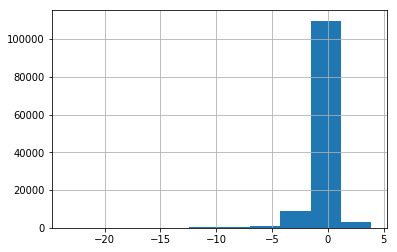

,card_id,target
0,C_ID_0ab67a22ab,-1.748821
1,C_ID_130fd0cbdd,-0.300433
2,C_ID_b709037bc5,-0.991384
3,C_ID_d27d835a9f,-0.048276
4,C_ID_2b5e3df5c2,-1.146984


In [27]:
final_pred = np.zeros(df_test.shape[0])

for i, (result) in enumerate(results) :
    print(i, "fold.")

    print("init rmse(1) with outlier    :", result['reg_err_val'])
    
    test_pred = pd.DataFrame()
    test_pred['final_pred'] = result['reg_model'].predict(df_test[features], num_iteration = result['reg_model'].best_iteration).reshape(-1)

    final_pred += test_pred['final_pred'].values.reshape(-1) / k

    print("---------------------------------------------------")
    
submission = pd.DataFrame()
submission['card_id'] = df_test['card_id'].values
submission['target'] = final_pred
submission.to_csv('submission_single.csv', index = False)
submission['target'].hist()
plt.show()
submission.head()

In [28]:
def find_best_result(pred_with_out, pred_without_out, prob, target) :
    rmse = []
    threshold = []
    
    pred_with_out = pred_with_out.copy()
    pred_without_out = pred_without_out.copy()
    prob = prob.copy()
    
    for t in np.arange(0.0, 1.01, 0.001) :
        pred_dummy = pred_without_out.copy()
        out_idx = np.where(prob>=t)[0]
        pred_dummy[out_idx] = pred_with_out[out_idx]
        rmse.append(get_rmse(target, pred_dummy))
        threshold.append(t)

    best_idx = np.argmin(np.array(rmse))
    return rmse[best_idx], threshold[best_idx]

final_error_avg = 0
final_pred = np.zeros(df_test.shape[0])

for i, (result) in enumerate(results) :
    print(i, "fold.")
    df = val_result.loc[val_result['idx'].isin(result['val_idx']), :].copy()
    
    print("init rmse(1) with outlier    :", result['reg_err_val'])
    print("init rmse(2) without outlier :", get_rmse(df['reg_pred_no_outlier'].values, df['target'].values))
    print('')
    
    df['final_pred'] = df['reg_pred_no_outlier'].values
    
    print("[phase_1] mixing rmse(2) with mean of rmse(1), rmse(2)..")
    rmse, threshold1 = find_best_result(df['reg_pred'].values*0.5+df['reg_pred_no_outlier'].values*0.5, df['final_pred'].values, df['clf_pred'].values, df['target'].values)
    print("best rmse :", rmse, " at", threshold1, " threshold", end = "\n\n") 
    
    idx = df['clf_pred'] >= threshold1
    df.loc[idx, 'final_pred'] = (df.loc[idx, 'reg_pred'] + df.loc[idx, 'reg_pred_no_outlier'])/2
    
    print("[phase_2] mixing phase_1 result with rmse(1)..")
    rmse, threshold2 = find_best_result(df['reg_pred'], df['final_pred'].values, df['clf_pred'].values, df['target'].values)
    print("best rmse :", rmse, " at", threshold2, " threshold", end = "\n\n") 
    
    idx = df['clf_pred'] >= threshold2
    df.loc[idx, 'final_pred'] = df.loc[idx, 'reg_pred']

    print("lowest prediction ajdusting...")
    out_threshold = df.sort_values(by='final_pred')['final_pred'].values[0]
    print(df.loc[df['final_pred']<=out_threshold, :])
    df.loc[df['final_pred']<=out_threshold, 'final_pred'] = -33.218750
    
    #df.loc[df['final_pred']<=-20.3, 'final_pred'] = -33.218750
    #df.loc[df['clf_pred']>=0.59, 'final_pred'] = -33.218750
    
    final_error = get_rmse(df['final_pred'].values, df['target'].values)
    print("final error :", final_error, end = "\n\n")
    final_error_avg += final_error / k

    if use_ffm : df_test.loc[:, ffm_latent_cols] = get_ffm_vect(field_dict, df_test_onehot.values, result['reg_ffm_weight'])
    
    test_pred = pd.DataFrame()
    test_pred['reg_pred'] = result['reg_model'].predict(df_test[features], num_iteration = result['reg_model'].best_iteration).reshape(-1)
    test_pred['reg_pred_no_outlier'] = result['reg_model_no_outlier'].predict(df_test[features], num_iteration = result['reg_model_no_outlier'].best_iteration).reshape(-1)
    test_pred['clf_pred'] = result['clf_model'].predict(df_test[features], num_iteration = result['clf_model'].best_iteration).reshape(-1)
    test_pred['final_pred'] = test_pred['reg_pred_no_outlier']
    
    idx = test_pred['clf_pred'] >= threshold1
    test_pred.loc[idx, 'final_pred'] = (test_pred.loc[idx, 'reg_pred'] + test_pred.loc[idx, 'reg_pred_no_outlier']) / 2
    
    idx = test_pred['clf_pred'] >= threshold2
    test_pred.loc[idx, 'final_pred'] = test_pred.loc[idx, 'reg_pred']
    
    out_threshold = test_pred.sort_values(by='final_pred')['final_pred'].values[20]
    test_pred.loc[test_pred['final_pred']<=out_threshold, 'final_pred'] = -33.218750
    print(test_pred.loc[test_pred['final_pred']<=out_threshold, :])
    
    out_threshold = test_pred.sort_values(by='clf_pred', ascending = False)['clf_pred'].values[10]
    print(test_pred.loc[test_pred['clf_pred']>=out_threshold, :])
    test_pred.loc[test_pred['clf_pred']>=out_threshold, 'final_pred'] = -33.218750
    
    #test_pred.loc[test_pred['final_pred']<=-20.3, 'final_pred'] = -33.218750
    #test_pred.loc[test_pred['clf_pred']>=0.59, 'final_pred'] = -33.218750
    
    final_pred += test_pred['final_pred'].values.reshape(-1) / k

    print("---------------------------------------------------")
    
print("Average final error :", final_error_avg)

0 fold.
init rmse(1) with outlier    : 3.628448205500386
init rmse(2) without outlier : nan

[phase_1] mixing rmse(2) with mean of rmse(1), rmse(2)..
best rmse : nan  at 0.0  threshold

[phase_2] mixing phase_1 result with rmse(1)..
best rmse : nan  at 0.0  threshold

lowest prediction ajdusting...
Empty DataFrame
Columns: [clf_pred, idx, reg_pred, reg_pred_no_outlier, target, final_pred]
Index: []
final error : nan



KeyboardInterrupt: 

In [ ]:
submission = pd.DataFrame()
submission['card_id'] = df_test['card_id'].values
submission['target'] = final_pred
submission.to_csv('submission.csv', index = False)
submission['target'].hist()
plt.show()
submission.head()